In [2]:
# Standard Library
import os
import time
import re
import json
import gzip
import shutil
import tarfile
import subprocess
from pathlib import Path
from typing import TypedDict, List, Dict, Any
from urllib.parse import urljoin, urlparse, parse_qs, unquote
import gzip
import pandas as pd
import numpy as np
import json
import re
from collections import defaultdict
from pathlib import Path

# Third-Party Libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from openai import OpenAI
from IPython.display import display, Markdown
from geofetch import Geofetcher

# Bioinformatics
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import gseapy as gp
from geofetch import Geofetcher
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import scanpy as sc
from sanbomics.plots import volcano

# LangChain/LangGraph
from langgraph.graph import StateGraph
from langchain_core.runnables import RunnableLambda

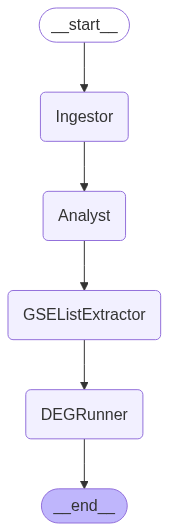

In [3]:
API_KEY = ''
os.environ['OPENAI_API_KEY']=API_KEY
client = OpenAI()
class AgentState(TypedDict):
    query_gene: str
    pathway_info: Dict[str, Any]
    metadata: Dict[str, Any]
    gse_list: list
    research_plan: str
    selected_gse: str  # ⬅️ now added
    selected_gses: List[str]  # ✅ new field for multiple GSEs
    deg_results: Dict[str, str]  # ✅ map GSE → output CSV path

# Utility to extract all GSE IDs from plan
def extract_all_gse_ids(plan_text: str) -> List[str]:
    return re.findall(r"GSE\d{5,}", plan_text)

def extract_gse_from_research_plan(state: AgentState) -> AgentState:
    plan = state.get("research_plan", "")
    match = re.search(r"GSE\d{5,}", plan)
    if match:
        selected_gse = match.group(0)
        print(f"🔍 Extracted GSE ID: {selected_gse}")
        return {**state, "selected_gse": selected_gse}
    else:
        print("⚠️ No GSE ID found in research plan.")
        return state

# LangGraph node: Extract GSEs from research plan and update state
def extract_gse_list_from_plan(state: AgentState) -> AgentState:
    plan = state.get("research_plan", "")
    gse_ids = extract_all_gse_ids(plan)
    print(f"🔍 Extracted GSE IDs: {gse_ids}")
    return {**state, "selected_gses": gse_ids}

# ----------------------------------------
# Utility functions (LLM + GEO search)
# ----------------------------------------



def generate_pathway_info(query_gene, model="gpt-4o-mini", temperature=0.3):
    prompt = f"""
You are a biomedical assistant.

Given the gene {query_gene}, return:
1. Key gene symbols based on query.
2. Drugs or compounds that inhibit this pathway or {query_gene}'s activity.
3. The disease areas or biological processes this pathway is involved in.

Provide answers in JSON format with keys: "genes", "drugs", "pathways"
    """
    completion = client.chat.completions.create(
        model=model,
        temperature=temperature,
        messages=[{"role": "user", "content": prompt}]
    )
    content = completion.choices[0].message.content
    return extract_json_block(content)



def scrape_organism_from_geo_html(geo_accession):
    url = f"https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc={geo_accession}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        organism_row = soup.find("td", string="Organism")
        if organism_row and organism_row.find_next_sibling("td"):
            return organism_row.find_next_sibling("td").text.strip()
    except Exception as e:
        print(f"⚠️ Failed to scrape organism for {geo_accession}: {e}")
    return "Unknown"

def search_geo_datasets(keyword, retmax=10):
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    params = {
        "db": "gds",
        "term": keyword,
        "retmode": "json",
        "retmax": retmax
    }
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    return response.json().get("esearchresult", {}).get("idlist", [])

def fetch_gse_accessions(id_list):
    if not id_list:
        return {}
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"
    params = {
        "db": "gds",
        "id": ",".join(id_list),
        "retmode": "json"
    }
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    summaries = response.json().get("result", {})
    summaries.pop("uids", None)
    gse_dict = {}
    for uid, info in summaries.items():
        accession = info.get("accession")
        title = info.get("title")
        link = f"https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc={accession}"
        organism = scrape_organism_from_geo_html(accession)
        gse_dict[accession] = {
            "title": title,
            "organism": organism,
            "link": link
        }
    return gse_dict

def search_geo_items(item_list, label="gene", max_results=5):
    results = {}
    for item in item_list:
        query = f"{item} AND rna-seq"
        print(f"🔍 Searching GEO for {label}: {item}")
        ids = search_geo_datasets(query, retmax=max_results)
        datasets = fetch_gse_accessions(ids)
        results[item] = datasets
        time.sleep(0.3)
    return results

def get_geofetch_projects(gse_list, metadata_folder="geofetch_metadata"):
    geof = Geofetcher(
        processed=True,
        acc_anno=True,
        discard_soft=True,
        metadata_folder=metadata_folder
    )
    projects = {}
    for gse in gse_list:
        try:
            print(f"📥 Fetching metadata for {gse}")
            result = geof.get_projects(gse)
            projects.update(result)
        except Exception as e:
            print(f"❌ Failed to fetch {gse}: {e}")
    return projects

import subprocess
def download_processed_files_via_cli(gse_list, output_dir="geofetch_metadata", overwrite=False):
    for gse in gse_list:
        gse_path = os.path.join(output_dir, gse)
        if os.path.exists(gse_path) and not overwrite:
            print(f"✅ {gse}: already exists at {gse_path}, skipping.")
            continue
        try:
            subprocess.run(
                ["geofetch", "-i", gse, "--processed", "-m", output_dir],
                check=True
            )
            print(f"✅ Finished downloading for {gse}")
        except subprocess.CalledProcessError as e:
            print(f"❌ geofetch failed for {gse}: {e}")

def save_combined_metadata_csv_from_state(state: Dict, csv_path: str = "geofetch_metadata/combined_metadata.csv") -> pd.DataFrame:
    metadata = state.get("metadata", {})
    if not metadata:
        raise ValueError("No metadata found in the agent state.")

    all_dfs = []
    for gse, project in metadata.items():
        try:
            df = project.sample_table.copy()
            df["source_gse"] = gse
            all_dfs.append(df)
        except Exception as e:
            print(f"⚠️ Failed to extract sample_table from {gse}: {e}")

    if not all_dfs:
        raise ValueError("No sample tables to save.")

    combined_df = pd.concat(all_dfs, ignore_index=True)
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    combined_df.to_csv(csv_path, index=False)
    print(f"✅ Combined metadata saved to: {os.path.abspath(csv_path)}")
    return combined_df



### scrapesupplementary function tested ###

def scrape_geo_supplementary_downloads(gse_id: str):
    """
    Scrape the GEO page for a given GSE ID and return a list of supplementary
    files that are .tar, .gz, or .tar.gz with valid HTTP download links.

    Returns:
        List of tuples: (file_name, http_download_url)
    """
    base_url = "https://www.ncbi.nlm.nih.gov"
    url = f"{base_url}/geo/query/acc.cgi?acc={gse_id}"

    try:
        response = requests.get(url)
        response.raise_for_status()

        soup = BeautifulSoup(response.text, "html.parser")
        tables = soup.find_all("table")

        for table in tables:
            if "Supplementary file" in table.text:
                rows = table.find_all("tr")
                files = []

                for row in rows[1:]:  # skip header
                    cols = row.find_all("td")
                    if len(cols) >= 3:
                        file_name = cols[0].text.strip()
                        if any(ext in file_name for ext in [".tar", ".gz"]):
                            all_links = cols[2].find_all("a", href=True)
                            for a in all_links:
                                href = a["href"]
                                if href.startswith("/geo/download"):
                                    files.append((file_name, urljoin(base_url, href)))
                                    break
                                elif href.startswith("http"):
                                    files.append((file_name, href))
                                    break

                return files

        return []

    except Exception:
        return []
def ingest_and_prepare(state: dict) -> dict:
    query_gene = state["query_gene"]
    pathway_info = generate_pathway_info(query_gene)
    gene_list = pathway_info.get("genes", [])
    drug_list = pathway_info.get("drugs", [])

    gene_results = search_geo_items(gene_list, label="gene")
    drug_results = search_geo_items(drug_list, label="drug")

    all_gse = set()
    for r in [gene_results, drug_results]:
        for v in r.values():
            all_gse.update(v.keys())
    all_gse = list(all_gse)

    # ----------------------------------------
    # Download each GSE using embedded logic
    # ----------------------------------------
    base_dir = Path("rna_seq_analysis")
    for gse_id in all_gse:
        download_dir = base_dir / gse_id

        if download_dir.exists() and any(download_dir.iterdir()):
            print(f"📁 Skipping {gse_id}: folder already exists.")
            continue

        download_dir.mkdir(parents=True, exist_ok=True)
        files = scrape_geo_supplementary_downloads(gse_id)
        if not files:
            print(f"⚠️ No supplementary files found for {gse_id}")
            continue

        file_name, url = files[0]
        if not file_name:
            parsed = urlparse(url)
            qs = parse_qs(parsed.query)
            file_name = unquote(qs.get("file", ["unnamed_file"])[0])

        file_path = download_dir / file_name
        print(f"📥 Downloading {file_name} → {file_path.as_posix()}")

        try:
            subprocess.run(["curl", "-L", "-o", file_path.as_posix(), url], check=True)
        except subprocess.CalledProcessError as e:
            print(f"❌ Download failed for {gse_id}: {e}")
            continue

        try:
            if tarfile.is_tarfile(file_path):
                print("🗂️ Extracting TAR...")
                with tarfile.open(file_path, "r:*") as tar:
                    tar.extractall(path=download_dir)
            elif file_path.suffix == ".gz" and not file_path.name.endswith(".tar.gz"):
                unzipped_path = file_path.with_suffix("")
                print("🗂️ Extracting GZ...")
                with gzip.open(file_path, 'rb') as f_in:
                    with open(unzipped_path, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
        except Exception as e:
            print(f"⚠️ Extraction failed for {gse_id}: {e}")
            continue

    # ----------------------------------------
    # Continue with metadata and return
    # ----------------------------------------
    metadata = get_geofetch_projects(all_gse, metadata_folder="geofetch_metadata")
    download_processed_files_via_cli(all_gse, output_dir="geofetch_metadata")

    try:
        save_combined_metadata_csv_from_state({"metadata": metadata})
    except Exception as e:
        print(f"⚠️ Failed to save metadata CSV: {e}")

    return {
        "query_gene": query_gene,
        "pathway_info": pathway_info,
        "metadata": metadata,
        "gse_list": all_gse
    }


# ----------------------------------------
# Agent 2: Analyst node
# ----------------------------------------

def analyze_metadata_and_plan(state: AgentState) -> AgentState:
    metadata = state["metadata"]
    drug_list = state["pathway_info"].get("drugs", [])
    query_gene = state["query_gene"]
    selected = []

    for gse, project in metadata.items():
        df = project.sample_table
        if "processed_file_ftp" in df.columns and df["processed_file_ftp"].notna().any():
            if any(drug.lower() in df.to_string().lower() for drug in drug_list):
                selected.append((gse, df.shape[0]))

    plan = f"🧬 Research Plan for {query_gene} and drugs {drug_list}:\n"
    if not selected:
        plan += "No relevant processed datasets were found.\n"
    else:
        plan += f"{len(selected)} datasets selected:\n"
        for gse, n in selected:
            plan += f"  - {gse} ({n} samples)\n"
        plan += "\nNext: perform differential expression and gene signature clustering."

    return {**state, "research_plan": plan}


def analyze_metadata_and_plan(state: AgentState) -> AgentState:
    import pandas as pd
    import os

    csv_path = "geofetch_metadata/combined_metadata.csv"
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"❌ Metadata CSV not found at {csv_path}")

    df = pd.read_csv(csv_path)

    # Ensure required columns exist
    required_columns = {"sample_name", "sample_source_name_ch1", "sample_title"}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"❌ Metadata CSV must include columns: {required_columns}")

    # Take first 50 rows for LLM context
    selected_df = df[list(required_columns)].fillna("").head(50)
    table_preview = selected_df.to_markdown(index=False)

    query_gene = state["query_gene"]
    drug_list = state["pathway_info"].get("drugs", [])
    selected_df = df[["sample_name", "sample_source_name_ch1", "sample_title"]].fillna("").head(50)
    table_preview = selected_df.to_markdown(index=False)
    print("🧪 Table preview sent to LLM:\n", table_preview)  # ✅ Add this line

    # Build LLM prompt
    prompt = f"""
You are a biomedical research assistant.

The target gene is **{query_gene}**, and the related drugs of interest are: {', '.join(drug_list)}.

Below is a preview of sample metadata (first 50 rows) from multiple GEO studies. Each row includes:
- sample name
- sample source (cell line, tissue)
- sample title (may indicate treatment or condition)

Your task:
1. Identify which studies include drug-treated samples.
2. Identify the control groups if available.
3. Determine the sample types (e.g., cell lines or tissues).
4. Recommend studies and sample comparisons suitable for differential gene expression and drug-response signature analysis.

Respond with:
- GSE or study names (if known)
- The experimental comparison design
- Why the dataset is suitable (or not)
- Bullet points summarizing each recommended comparison

Sample Metadata Table:

"""

    # Call LLM
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        temperature=0.3,
        messages=[{"role": "user", "content": prompt}]
    )

    research_plan = response.choices[0].message.content.strip()

    return {
        **state,
        "research_plan": research_plan
    }

###
def analyze_metadata_and_plan(state: AgentState) -> AgentState:
    import pandas as pd
    import os

    csv_path = "geofetch_metadata/combined_metadata.csv"
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"❌ Metadata CSV not found at {csv_path}")

    df = pd.read_csv(csv_path)

    # Ensure required columns are available
    required_cols = ["gse", "sample_name", "sample_title", "sample_source_name_ch1", "sample_geo_accession"]
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"❌ Metadata CSV must contain the following columns: {required_cols}")

    # Clean and preview first 30 rows
    #preview_df = df[required_cols].fillna("").head(30)
    preview_df = df[required_cols].fillna("")
    preview_text = preview_df.to_string(index=False)

    query_gene = state["query_gene"]
    drug_list = state["pathway_info"].get("drugs", [])

    prompt = f"""
You are a biomedical research assistant.

The target gene is **{query_gene}** and the related drugs of interest are: {', '.join(drug_list)}.

Below is a preview of sample metadata from several GEO datasets.
Each row includes:
- GSE accession
- Sample name
- Sample title (may contain treatment or control info)
- Sample source (cell type or tissue)
- Sample GEO accession

Sample Metadata Table:
{preview_text}

Based on the sample names, titles, and sources:
1. Which GSE studies contain drug-treated samples and matching control groups?
2. What cell types or tissues are used?
3. Which treatments are applied? What are the controls?
4. Recommend GSEs and sample pairs suitable for differential gene expression to identify drug-response gene signatures.

Be specific, refer to GSE and sample names where possible, and explain why you recommend them.
"""

    # Call OpenAI LLM
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        temperature=0.3,
        messages=[{"role": "user", "content": prompt}]
    )

    research_plan = response.choices[0].message.content.strip()

    return {
        **state,
        "research_plan": research_plan
    }


# LangGraph node: Extract GSEs from research plan and update state
# Utility to extract all GSE IDs from plan
def extract_all_gse_ids(plan_text: str) -> List[str]:
    return re.findall(r"GSE\d{5,}", plan_text)
def extract_gse_list_from_plan(state: AgentState) -> AgentState:
    plan = state.get("research_plan", "")
    gse_ids = extract_all_gse_ids(plan)
    print(f"🔍 Extracted GSE IDs: {gse_ids}")
    return {**state, "selected_gses": gse_ids}

# DEG Agent with Enhanced LLM Classification from GEO Series Matrix


def decompress_all_in_dir(root_dir: str):
    """
    Decompress .gz and .tar files only if no uncompressed files exist in each GSE subdirectory.
    """
    print(f"🔍 Scanning for compressed files under: {root_dir}")
    for dirpath, _, filenames in os.walk(root_dir):
        # Skip decompression if the folder already has non-compressed data files
        if any(f.lower().endswith(('.csv', '.tsv', '.txt', '.xlsx')) for f in filenames):
            continue

        for fname in filenames:
            full_path = os.path.join(dirpath, fname)
            if tarfile.is_tarfile(full_path):
                try:
                    print(f"📦 Extracting TAR: {full_path}")
                    with tarfile.open(full_path, "r:*") as tar:
                        tar.extractall(path=dirpath)
                except Exception as e:
                    print(f"❌ Failed to extract TAR {fname}: {e}")
            elif fname.endswith(".gz") and not fname.endswith(".tar.gz"):
                out_path = os.path.join(dirpath, fname[:-3])
                if os.path.exists(out_path):
                    print(f"⚠️ Skipping (already exists): {out_path}")
                    continue
                try:
                    print(f"🗜️ Decompressing GZ: {full_path} → {out_path}")
                    with gzip.open(full_path, 'rb') as f_in:
                        with open(out_path, 'wb') as f_out:
                            shutil.copyfileobj(f_in, f_out)
                except Exception as e:
                    print(f"❌ Failed to decompress GZ {fname}: {e}")
def decompress_gse_in_dir(gse_id: str, root_dir: str = "rna_seq_analysis"):
    """
    Decompress .gz and .tar files only if no uncompressed files exist
    in the subdirectory for the specific GSE.
    """
    gse_path = os.path.join(root_dir, gse_id)
    print(f"🔍 Scanning for compressed files in: {gse_path}")
    if not os.path.exists(gse_path):
        print(f"⚠️ Directory does not exist: {gse_path}")
        return

    filenames = os.listdir(gse_path)
    if any(f.lower().endswith(('.csv', '.tsv', '.txt', '.xlsx')) for f in filenames):
        return

    for fname in filenames:
        full_path = os.path.join(gse_path, fname)
        if tarfile.is_tarfile(full_path):
            try:
                print(f"📦 Extracting TAR: {full_path}")
                with tarfile.open(full_path, "r:*") as tar:
                    tar.extractall(path=gse_path)
            except Exception as e:
                print(f"❌ Failed to extract TAR {fname}: {e}")
        elif fname.endswith(".gz") and not fname.endswith(".tar.gz"):
            out_path = os.path.join(gse_path, fname[:-3])
            if os.path.exists(out_path):
                print(f"⚠️ Skipping (already exists): {out_path}")
                continue
            try:
                print(f"🗜️ Decompressing GZ: {full_path} → {out_path}")
                with gzip.open(full_path, 'rb') as f_in:
                    with open(out_path, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
            except Exception as e:
                print(f"❌ Failed to decompress GZ {fname}: {e}")


def get_series_matrix_url(gse_id: str) -> str:
    """
    Find the final HTTP URL of the actual .series_matrix.txt.gz file
    for a given GEO study by first finding the FTP matrix directory,
    then scraping the listing page for the correct file.

    Args:
        gse_id (str): e.g. "GSE94840"

    Returns:
        str: Final download URL, or None if not found.
    """
    base_geo_url = "https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc="
    response = requests.get(base_geo_url + gse_id)
    response.raise_for_status()

    soup = BeautifulSoup(response.text, "html.parser")
    ftp_matrix_url = None

    # Step 1: find ftp:// link for Series Matrix File(s)
    for a in soup.find_all("a", href=True):
        href = a['href']
        if href.startswith("ftp://") and "matrix" in href and gse_id in href:
            ftp_matrix_url = href
            break

    if not ftp_matrix_url:
        return None

    # Step 2: Convert FTP to HTTPS to scrape the file listing page
    https_matrix_dir = ftp_matrix_url.replace("ftp://", "https://")

    response = requests.get(https_matrix_dir)
    response.raise_for_status()

    soup = BeautifulSoup(response.text, "html.parser")
    for a in soup.find_all("a", href=True):
        if a['href'].endswith("series_matrix.txt.gz"):
            # Return full HTTPS URL to the file
            return https_matrix_dir + a['href']

    return None



def download_series_matrix(gse_id, output_dir="geofetch_metadata"):
    url = get_series_matrix_url(gse_id)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    output_path = output_dir / f"{gse_id}_series_matrix.txt.gz"
    if output_path.exists():
        return str(output_path)
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(output_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        return str(output_path)
    else:
        raise FileNotFoundError(f"Could not download series matrix for {gse_id}")



def infer_conditions_with_labels_from_series_matrix(series_matrix_path, gse_id, max_samples=500):
    characteristics_matrix, sample_accessions = [], []
    with gzip.open(series_matrix_path, "rt", encoding="utf-8") as f:
        for line in f:
            if line.startswith("!Sample_characteristics_ch1"):
                values = line.strip().split("\t")[1:]
                characteristics_matrix.append(values)
            elif line.startswith("!Sample_geo_accession"):
                sample_accessions = line.strip().split("\t")[1:]
    if not characteristics_matrix or not sample_accessions:
        raise ValueError("Missing sample characteristics or accessions.")
    characteristics_matrix = list(zip(*characteristics_matrix))
    sample_data = [
        {"GSM": gsm.strip('"'), "characteristics": [c.strip('"') for c in char_fields if c.strip()]}
        for gsm, char_fields in zip(sample_accessions, characteristics_matrix)
    ]
    metadata_json = json.dumps(sample_data[:max_samples], indent=2)
    prompt = f"""
You are a biomedical data curator.

Below is a list of samples from GEO study **{gse_id}**. Each sample includes multiple characteristics such as diagnosis, sex, age, and treatment.

Your task:
1. Classify each sample as either part of the **control** group or the **treated/disease** group.
2. Extract a **short biological label** for each sample from its characteristics (e.g., \"ALS\", \"healthy\", \"treated with ..\").

Here is the list:
```json
{metadata_json}
```
Return only a **valid JSON object** like:
```json
{{
  "GSM8077414": {{ "group": "control", "label": "healthy" }},
  "GSM8077415": {{ "group": "treated", "label": "ALS" }}
}}
---
"""
    response = client.chat.completions.create(
        model="gpt-4o",
        temperature=0.2,
        messages=[{"role": "user", "content": prompt}]
    )
    content = response.choices[0].message.content.strip()
    mapping = extract_json_block(content)
    if not isinstance(mapping, dict) or not all(isinstance(v, dict) and "group" in v and "label" in v for v in mapping.values()):
        raise ValueError("Invalid response from LLM")
    return mapping



def extract_json_block(text):
    """
    Extract the first valid JSON object block from text.
    Assumes the block is surrounded by ```json ... ``` or just {...}
    """
    import re
    import ast

    try:
        if "```json" in text:
            json_block = re.findall(r"```json\s*(\{.*?\})\s*```", text, re.DOTALL)
        else:
            json_block = re.findall(r"(\{.*\})", text, re.DOTALL)
        if json_block:
            return json.loads(json_block[0])
        else:
            return ast.literal_eval(text.strip())  # fallback
    except Exception as e:
        raise ValueError(f"Failed to extract valid JSON: {e}")


def extract_flexible_labels_from_series_matrix(series_matrix_path, gse_id, max_samples=600):
    """
    Parse a GEO Series Matrix file and use an LLM to extract biologically meaningful sample labels.

    Args:
        series_matrix_path (str): Path to the .txt.gz series matrix file.
        gse_id (str): GEO study ID.
        client: An OpenAI-compatible API client object.
        max_samples (int): Max number of samples to send to LLM (for token budget).

    Returns:
        dict: Mapping from GSM ID to flexible labels (as key-value fields).
    """
    characteristics_matrix, sample_accessions = [], []

    with gzip.open(series_matrix_path, "rt", encoding="utf-8") as f:
        for line in f:
            if line.startswith("!Sample_characteristics_ch1"):
                values = line.strip().split("\t")[1:]
                characteristics_matrix.append(values)
            elif line.startswith("!Sample_geo_accession"):
                sample_accessions = line.strip().split("\t")[1:]

    if not characteristics_matrix or not sample_accessions:
        raise ValueError("Missing sample characteristics or accessions.")

    # Transpose to per-sample view
    characteristics_matrix = list(zip(*characteristics_matrix))
    sample_data = [
        {
            "GSM": gsm.strip('"'),
            "characteristics": [c.strip('"') for c in char_fields if c.strip()]
        }
        for gsm, char_fields in zip(sample_accessions, characteristics_matrix)
    ]

    metadata_json = json.dumps(sample_data[:max_samples], indent=2)

    prompt = f"""
You are a biomedical data curator.

Below is a list of samples from GEO study **{gse_id}**. Each sample includes multiple characteristics such as diagnosis, sex, age, and treatment.

Your task:
1. Classify each sample as either part of the **control** group or the **treated/disease** group. This classification should be stored in the field called `condition`.
2. Extract all **biologically meaningful labels** from each sample (such as treatment, dose, time point, cell type, genotype, sex, etc.).
3. Return a dictionary mapping each sample's GSM ID to a dictionary of extracted fields and values.
4. The field names should be concise and biologically relevant (e.g., "treatment", "time", "dose").
5. Do not include null or irrelevant fields.

Here is the sample list:
```json
{metadata_json}
```

Please return only the final **valid JSON object**. Example format:
```json
{{
  "GSM123456": {{
    "condition": "treated",
    "treatment": "PGE2",
    "dose": "30nM",
    "time": "24 hr"
  }},
  "GSM123457": {{
    "condition": "control",
    "treatment": "Vehicle (DMSO)"
  }}
}}
"""

    # Call the LLM
    response = client.chat.completions.create(
        model="gpt-4o",
        temperature=0.2,
        messages=[{"role": "user", "content": prompt}]
    )
    content = response.choices[0].message.content.strip()

    # Extract JSON
    mapping = extract_json_block(content)

    if not isinstance(mapping, dict) or not all(isinstance(v, dict) for v in mapping.values()):
        raise ValueError("Invalid response format from LLM.")

    return mapping



def get_group_label_mapping_from_gse(gse_id, output_dir="geofetch_metadata", max_samples=30):
    path = download_series_matrix(gse_id, output_dir=output_dir)
    #return infer_conditions_with_labels_from_series_matrix(path, gse_id, max_samples=max_samples)
    return extract_flexible_labels_from_series_matrix(path, gse_id, max_samples=max_samples)


def download_and_extract_gse(gse_id, base_dir="rna_seq_analysis"):
    """
    Downloads and extracts supplementary files for a given GSE.
    """
    gse_dir = Path(base_dir) / gse_id
    gse_dir.mkdir(parents=True, exist_ok=True)

    files = scrape_geo_supplementary_downloads(gse_id)
    if not files:
        print(f"⚠️ No supplementary files found for {gse_id}")
        return str(gse_dir)

    file_name, url = files[0]
    if not file_name:
        parsed = urlparse(url)
        qs = parse_qs(parsed.query)
        file_name = unquote(qs.get("file", ["unnamed_file"])[0])

    file_path = gse_dir / file_name
    print(f"📥 Downloading {file_name} → {file_path.as_posix()}")

    try:
        subprocess.run(["curl", "-L", "-o", file_path.as_posix(), url], check=True)
    except subprocess.CalledProcessError as e:
        print(f"❌ Download failed for {gse_id}: {e}")
        return str(gse_dir)

    try:
        if tarfile.is_tarfile(file_path):
            print("🗂️ Extracting TAR...")
            with tarfile.open(file_path, "r:*") as tar:
                tar.extractall(path=gse_dir)
        elif file_path.suffix == ".gz" and not file_path.name.endswith(".tar.gz"):
            unzipped_path = file_path.with_suffix("")
            print("🗂️ Extracting GZ...")
            with gzip.open(file_path, 'rb') as f_in:
                with open(unzipped_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
    except Exception as e:
        print(f"⚠️ Extraction failed for {gse_id}: {e}")

def run_deg_for_multiple_gses_debug(state):
    gse_ids = state.get("selected_gses", [])
    if not gse_ids:
        print("No selected GSEs found.")
        return state
    deg_paths = {}

    # Pre-decompress all GSE folders
    decompress_all_in_dir("rna_seq_analysis")

    for gse_id in gse_ids:
        try:
            print(f"Running DESeq2 for: {gse_id}")
            download_dir = download_and_extract_gse(gse_id)
            counts_df = find_and_merge_count_files(gse_id)
            if counts_df is None or counts_df.empty:
                continue
            group_label_mapping = get_group_label_mapping_from_gse(gse_id)
            metadata_df = pd.DataFrame.from_dict(group_label_mapping, orient="index")
            metadata_df.index.name = "sample_geo_accession"
            metadata_df = metadata_df[["group"]].rename(columns={"group": "condition"})
            print(metadata_df)
            counts_df.columns = [gsm if gsm in metadata_df.index else gsm for gsm in counts_df.columns]
            valid_samples = metadata_df.index.intersection(counts_df.columns)
            counts_df = counts_df[valid_samples]
            metadata_df = metadata_df.loc[valid_samples]
            if counts_df.empty or metadata_df.empty:
                continue
            dds = DeseqDataSet(
                counts=counts_df.T,
                metadata=metadata_df,
                design_factors="condition",
                refit_cooks=True,
            )
            dds.deseq2()
            ds = DeseqStats(dds, contrast=["condition", "treated", "control"])
            ds.summary()
            output_csv = f"rna_seq_analysis/{gse_id}_deseq2_results.csv"
            ds.results_df.to_csv(output_csv, index=False)
            deg_paths[gse_id] = output_csv
        except Exception as e:
            print(f"Error running DESeq2 for {gse_id}: {e}")
    return {**state, "deg_results": deg_paths}



def find_and_merge_count_files(gse_id: str, base_dir="rna_seq_analysis") -> pd.DataFrame:
    gse_dir = Path(base_dir) / gse_id
    if not gse_dir.exists():
        print(f"❌ GSE folder not found: {gse_dir}")
        return None

    patterns = ["*.csv", "*.tsv", "*.txt", "*.xlsx", "*.gz"]
    files = []
    seen_uncompressed = set()
    for pattern in patterns:
        for f in gse_dir.glob(pattern):
            if f.suffix == ".gz":
                uncompressed_name = f.with_suffix("")
                if uncompressed_name.name in seen_uncompressed:
                    print(f"⚠️ Skipping compressed duplicate: {f.name}")
                    continue
            else:
                seen_uncompressed.add(f.name)
            files.append(f)

    if not files:
        print(f"⚠️ No count files found in {gse_dir}")
        return None

    print(f"🔍 Found {len(files)} count files for {gse_id}")

    # Handle single uncompressed file
    uncompressed_files = [f for f in files if f.suffix != ".gz"]
    if len(uncompressed_files) == 1:
        file = uncompressed_files[0]
        print(f"📄 Only one uncompressed count file found: {file.name} — attempting to load without merging.")
        try:
            if file.suffix == ".csv":
                df = pd.read_csv(file)
            elif file.suffix == ".xlsx":
                df = pd.read_excel(file)
            else:  # .txt or .tsv
                df = pd.read_csv(file, sep="\t")

            #df.columns = df.columns.astype(str)

            # Set first column as gene index
            #gene_col = df.columns[0]
            #df.set_index(gene_col, inplace=True)

            # Keep only numeric sample columns
            #numeric_df = df.apply(pd.to_numeric, errors='coerce')
            #numeric_df = numeric_df.dropna(axis=1, how='all')  # Drop fully non-numeric
            #numeric_df = numeric_df.fillna(0).astype(int)
  
            df.columns = df.columns.astype(str)

            # Set the first column (likely gene names) as index
            gene_col = df.columns[0]
            df.set_index(gene_col, inplace=True)

                        
            annotation_keywords = {"gene_length", "length", "start", "end", "strand", "chromosome", "chr"}
            
            # Identify numeric sample columns and exclude known annotation fields
            numeric_cols = []
            for col in df.columns:
                col_lower = col.strip().lower()
                if any(key in col_lower for key in annotation_keywords):
                    continue
                try:
                    pd.to_numeric(df[col], errors='raise')
                    numeric_cols.append(col)
                except Exception:
                    continue
            
            # Filter to only good sample columns
            df = df[numeric_cols]
            
            # Final numeric conversion and zero fill
            numeric_df = df.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)          
             
            
            
            # Conditionally apply +1 normalization if any zeros are present
            if (numeric_df == 0).any().any():
                print("⚠️ Zero counts detected — applying +1 normalization.")
                numeric_df += 1
            else:
                print("✅ No zero counts — no normalization applied.")

            print(f"✅ Single count file processed. Shape: {numeric_df.shape}")
            return numeric_df

        except Exception as e:
            print(f"❌ Failed to load single count file: {e}")
            return None

    # Proceed with merging multiple files
    merged_df = None
    used_column_names = set()

    for file in files:
        try:
            sample_base = file.stem.split("_")[0] if "_" in file.stem else file.stem

            if file.suffix == ".gz":
                with gzip.open(file, 'rt') as f:
                    df = pd.read_csv(f, sep="\t", header=0)
            elif file.suffix == ".csv":
                df = pd.read_csv(file, header=0)
            elif file.suffix == ".xlsx":
                df = pd.read_excel(file, header=0)
            else:
                df = pd.read_csv(file, sep="\t", header=0)

            if df.shape[1] < 2:
                raise ValueError(f"{file.name} has fewer than 2 columns, cannot extract count data.")

            df.columns = ['Gene'] + [f"V{i}" for i in range(1, df.shape[1])]
            df.set_index('Gene', inplace=True)
            df = df.apply(pd.to_numeric, errors="coerce").fillna(0)
            df = df.iloc[:, [0]]  # First data column only

            col_name = sample_base
            counter = 1
            while col_name in used_column_names:
                col_name = f"{sample_base}_{counter}"
                counter += 1
            used_column_names.add(col_name)
            df.columns = [col_name]

            if merged_df is None:
                merged_df = df
            else:
                merged_df = merged_df.join(df, how="outer")

        except Exception as e:
            print(f"❌ Failed to read {file.name}: {e}")

    if merged_df is not None:
        merged_df = merged_df.fillna(0).astype(int)

        if (merged_df == 0).any().any():
            print("⚠️ Zero counts detected in merged matrix — applying +1 normalization.")
            merged_df += 1
        else:
            print("✅ No zero counts — no normalization applied.")

        print(f"✅ Final merged count matrix shape: {merged_df.shape}")
        return merged_df
    else:
        print("❌ No valid count data could be merged.")
        return None


def load_de_result_file(file_path: Path) -> pd.DataFrame:
    """
    Attempts to load a DE result table and validate expected DE columns.

    Args:
        file_path (Path): Path to the DE results file.

    Returns:
        pd.DataFrame: Parsed DE results with gene index, or None.
    """
    try:
        if file_path.suffix == ".gz":
            opener = gzip.open
            mode = 'rt'
        else:
            opener = open
            mode = 'r'

        with opener(file_path, mode) as f:
            # Try different separators
            for sep in ["\t", ","]:
                f.seek(0)
                df = pd.read_csv(f, sep=sep)
                if any(col in df.columns for col in ["log2FoldChange", "pvalue", "padj", "stat", "baseMean"]):
                    df.columns = df.columns.str.strip()
                    gene_col = df.columns[0]
                    df.set_index(gene_col, inplace=True)
                    print(f"✅ Loaded DE result file: {file_path.name} — shape: {df.shape}")
                    return df
        print(f"⚠️ No DE columns found in file: {file_path.name}")
        return None
    except Exception as e:
        print(f"❌ Failed to read DE result file {file_path.name}: {e}")
        return None






def annotate_clustermap_with_metadata(grapher, metadata_df):
    print("🔍 Starting clustermap annotation...")

    # 1. Build treatment label to GSM mapping
    label_map = {}
    for gsm, row in metadata_df.iterrows():
        label = str(row['treatment']).strip()
        if label not in label_map:
            label_map[label] = []
        label_map[label].append(gsm)
    print(f"✅ Built label_map with labels: {list(label_map.keys())}")

    # 2. Check if column names in grapher need remapping
    if not all(label in metadata_df.index for label in grapher.columns):
        print("⚠️ Column names in grapher are not pure GSM IDs. Attempting to remap based on treatment labels...")
        new_cols = []
        for label in grapher.columns:
            # Assume format: "Vehicle (DMSO)_GSM7757588"
            try:
                treatment_label = "_".join(label.split('_')[:-1])  # everything except last piece
            except Exception as e:
                raise ValueError(f"❌ Failed to parse treatment label from: {label} — {e}")

            matches = label_map.get(treatment_label)
            if not matches:
                raise ValueError(f"❌ No GSM match found for treatment label: {treatment_label} (from full label: {label})")
            new_cols.append(matches[0])  # Use only the first match
            print(f"🔄 Remapped {label} -> {matches[0]}")
        grapher.columns = new_cols
    else:
        print("✅ All grapher columns are valid GSM IDs")

    # 3. Extract annotations
    annotation_cols = ["condition", "treatment", "time"]
    missing_cols = [col for col in annotation_cols if col not in metadata_df.columns]
    if missing_cols:
        raise KeyError(f"❌ Metadata is missing required columns: {missing_cols}")

    try:
        col_annotation_df = metadata_df.loc[grapher.columns, annotation_cols].copy()
    except KeyError as e:
        raise KeyError(f"❌ Some GSM IDs in grapher not found in metadata: {e}")

    col_annotation_df = col_annotation_df.applymap(lambda x: str(x).strip() if pd.notna(x) else "NA")
    print("✅ Extracted column annotations.")

    # 4. Create annotation color maps
    col_colors = pd.DataFrame(index=col_annotation_df.index)
    palette_cache = {}

    palette_map = {
        "condition": "Set1",
        "treatment": "Dark2",
        "time": "Paired"
    }

    for col in annotation_cols:
        unique_vals = sorted(col_annotation_df[col].unique())
        real_vals = [v for v in unique_vals if v != "NA"]
        print(f"🎨 Mapping colors for {col}: {real_vals}")
        palette_name = palette_map.get(col, "Set2")
        palette = sns.color_palette(palette_name, len(real_vals))
        lut = dict(zip(real_vals, palette))
        lut["NA"] = "#ffffff"
        col_colors[col] = col_annotation_df[col].map(lut)
        palette_cache[col] = lut

    print("✅ Created color palettes for annotations.")

    # 5. Plot the clustermap
    print("📊 Generating clustermap...")
    g = sns.clustermap(
        grapher,
        z_score=0,
        cmap="RdYlBu_r",
        col_cluster=False,
        col_colors=col_colors
    )

    # 6. Add legend
    legend_handles = []
    for col, lut in palette_cache.items():
        for label, color in lut.items():
            legend_handles.append(Patch(facecolor=color, label=f"{col}: {label}"))

    plt.gcf().legend(handles=legend_handles, bbox_to_anchor=(1.02, 1), loc="upper left", title="Annotations")
    plt.show()
    print("✅ Clustermap rendered successfully.")




########## version 2
# Step 1: Extract Metadata
# -------------------------------

# -------------------------------
# Step 2: Remap Expression Columns
# -------------------------------
def extract_json_block(text):
    try:
        start = text.index("{")
        end = text.rindex("}") + 1
        return json.loads(text[start:end])
    except Exception as e:
        print(f"\u274c Failed to extract JSON: {e}")
        return {}
def parse_series_matrix_to_sample_table(series_matrix_path):
    """
    Parse Series Matrix file into a structured table per sample.
    Returns a list of dicts: each dict = all metadata for one sample.
    """
    metadata_fields = {}
    with gzip.open(series_matrix_path, "rt", encoding="utf-8") as f:
        for line in f:
            if line.startswith("!Sample_"):
                key, *values = line.strip().split("\t")
                key = key.replace("!Sample_", "")
                metadata_fields.setdefault(key, []).extend(values)

    # Transpose: per sample
    num_samples = len(next(iter(metadata_fields.values())))
    sample_table = []
    for i in range(num_samples):
        sample_entry = {}
        for key, value_list in metadata_fields.items():
            if i < len(value_list):
                sample_entry[key] = value_list[i].strip('"')
        sample_table.append(sample_entry)

    return sample_table


def construct_prompt_to_match_samples_and_generate_metadata(sample_table, count_labels, gse_id):
    """
    Construct an LLM prompt to:
    - Identify which metadata field contains the count sample labels
    - Extract biologically meaningful metadata from each sample
    """
    prompt_data = {
        "GEO": gse_id,
        "sample_labels_from_counts": count_labels,
        "samples_metadata": sample_table[:300]  # send only a subset to stay within token limits
    }

    prompt = f"""
You are a biomedical data curator.

Below is a list of samples from GEO study **{gse_id}**. Each sample contains metadata fields like `geo_accession`, `title`, `description`, and `characteristics`.

Also included is a list of **sample labels from the count matrix**, such as:
```json
#{json.dumps(list(count_labels[:15]), indent=2)}
{json.dumps(list(count_labels[:]), indent=2)}
    Your tasks:

Identify which metadata field (e.g., title, description, characteristics) contains the matching sample labels.

Use the matched field to define sample identity (e.g., "K401", "K402").

For each matched sample, generate a JSON object containing:

"condition": Must be either "control" or "treated".

Any other relevant fields: "treatment", "time", "dose", etc.

Return a dictionary mapping the sample labels (e.g., "K401") to structured metadata.

Here is the metadata table:

{json.dumps(prompt_data["samples_metadata"], indent=2)}
Only return the final JSON dictionary — no explanations.
"""
    return prompt


def split_sample_table(sample_table, batch_size=100):
    """Yield batches of the sample_table."""
    for i in range(0, len(sample_table), batch_size):
        yield sample_table[i:i + batch_size]



def extract_labels_using_llm(series_matrix_path, gse_id, client,sample_labels_from_counts):
#Full pipeline: parse matrix, build prompt, call LLM, return metadata per count sample label.

    print(f"📂 Parsing series matrix: {series_matrix_path}")
    sample_table = parse_series_matrix_to_sample_table(series_matrix_path)
    print(f"✅ Parsed {len(sample_table)} samples")
    print(f"🧠 Building prompt for {len(sample_labels_from_counts)} sample labels...")
    prompt = construct_prompt_to_match_samples_and_generate_metadata(sample_table, sample_labels_from_counts, gse_id)
    
    print("💬 Sending prompt to LLM...")
    response = client.chat.completions.create(
        model="gpt-4o",
        temperature=0.2,
        messages=[{"role": "user", "content": prompt}]
    )
    
    content = response.choices[0].message.content.strip()
    print(f"🧾 LLM Response preview:\n{content[:300]}...")
    
    metadata_by_label = extract_json_block(content)
    print(f"✅ Extracted metadata for {len(metadata_by_label)} sample labels")
    
    return metadata_by_label

#################
def extract_labels_using_llm(series_matrix_path, gse_id, client, sample_labels_from_counts, batch_size=100):
    """
    Full pipeline: parse matrix, build prompt, call LLM for batches, return combined metadata.
    """
    print(f"📂 Parsing series matrix: {series_matrix_path}")
    sample_table = parse_series_matrix_to_sample_table(series_matrix_path)
    print(f"✅ Parsed {len(sample_table)} samples")

    all_metadata = {}
    for batch_num, batch_table in enumerate(split_sample_table(sample_table, batch_size=batch_size), 1):
        print(f"🧠 Building prompt for batch {batch_num} with {len(batch_table)} samples...")
        prompt = construct_prompt_to_match_samples_and_generate_metadata(batch_table, sample_labels_from_counts, gse_id)

        print(f"💬 Sending batch {batch_num} prompt to LLM...")
        response = client.chat.completions.create(
            model="gpt-4o",
            temperature=0.2,
            messages=[{"role": "user", "content": prompt}]
        )

        content = response.choices[0].message.content.strip()
        print(f"🧾 Batch {batch_num} LLM Response preview:\n{content[:300]}...")

        batch_metadata = extract_json_block(content)
        print(f"✅ Extracted metadata for {len(batch_metadata)} sample labels in batch {batch_num}")

        all_metadata.update(batch_metadata)

    print(f"🎉 Completed extraction for {len(all_metadata)} sample labels across all batches")
    return all_metadata

#############


######## new #########


###############


########## test 
def run_deg_for_single_gse_debug(state):
    gse_id = state.get("selected_gse")
    if not gse_id:
        print("No selected GSE found.")
        return state

    deg_paths = {}
    decompress_gse_in_dir(gse_id)
    series_matrix_path = f"geofetch_metadata/{gse_id}_series_matrix.txt.gz"

    try:
        print(f"Running DESeq2 for: {gse_id}")
        download_dir = download_and_extract_gse(gse_id)
        counts_df = find_and_merge_count_files(gse_id)

        if counts_df is None:
            print(f"⚠️ No count matrix found for {gse_id}. Trying to load DE results directly...")
            gse_dir = Path("rna_seq_analysis") / gse_id
            for file in gse_dir.glob("*"):
                if file.suffix in [".txt", ".tsv", ".csv", ".gz"]:
                    de_df = load_de_result_file(file)
                    if de_df is not None:
                        output_csv = f"rna_seq_analysis/{gse_id}_de_results_direct.csv"
                        de_df.to_csv(output_csv)
                        deg_paths[gse_id] = output_csv
                        print(f"✅ DE result loaded and saved: {output_csv}")
                        return {**state, "deg_results": deg_paths}
            print(f"❌ No DE result files found in {gse_dir}")
            return state

        print(counts_df)

        sample_labels_from_counts = counts_df.columns
        group_label_mapping, name_map = extract_labels_using_llm(
            series_matrix_path, gse_id, client, sample_labels_from_counts
        )

        # Rename counts_df columns to unique names
        col_map = {orig: name_map.get(orig, orig) for orig in counts_df.columns}
        counts_df = counts_df.rename(columns=col_map)

        # Build metadata DataFrame and rename to unique names
        metadata_df = pd.DataFrame.from_dict(group_label_mapping, orient="index")
        metadata_df.index = [name_map.get(idx, idx) for idx in metadata_df.index]
        metadata_df.index.name = "sample_geo_accession"

        # Align counts + metadata
        valid_samples = metadata_df.index.intersection(counts_df.columns)
        counts_df = counts_df[valid_samples]
        metadata_df = metadata_df.loc[valid_samples]

        if counts_df.shape[1] == 0:
            raise ValueError("❌ No valid samples left after alignment — cannot run DESeq2.")

        tcounts = counts_df.T
        inference = DefaultInference(n_cpus=4)
        dds = DeseqDataSet(
            counts=tcounts,
            metadata=metadata_df,
            design_factors="condition",
            refit_cooks=True,
            inference=inference,
        )

        dds.fit_size_factors()
        dds.fit_genewise_dispersions()
        dds.fit_dispersion_trend()
        dds.fit_dispersion_prior()
        print(f"logres_prior={dds.uns['_squared_logres']}, sigma_prior={dds.uns['prior_disp_var']}")
        dds.fit_MAP_dispersions()
        dds.fit_LFC()
        dds.calculate_cooks()

        if dds.refit_cooks:
            dds.refit()

        stat_res = DeseqStats(
            dds, alpha=0.05, contrast=["condition", "treated", "control"],
            cooks_filter=True, independent_filter=True
        )
        stat_res.summary()
        res = stat_res.results_df
        output_csv = f"rna_seq_analysis/{gse_id}_deseq2_results.csv"
        res.to_csv(output_csv, index=False)
        deg_paths[gse_id] = output_csv
        print(f"✅ DESeq2 results saved: {output_csv}")

        filtered_df = res[
            (res["padj"] < 0.05) & (res["log2FoldChange"].abs() > 1)
        ]
        print(f"🧬 {filtered_df.shape[0]} significant genes found")

        # Additional visualization + analysis
        dds.layers["log1p"] = np.log1p(dds.layers["normed_counts"])
        sigs = res[(res.padj < 0.05) & (abs(res.log2FoldChange) > 1.5)]
        dds_sigs = dds[:, sigs.index]

        grapher = pd.DataFrame(
            dds_sigs.layers['log1p'],
            index=dds_sigs.obs_names,
            columns=dds_sigs.var_names
        ).T
        grapher.index.name = "gene"
        grapher_cp = grapher.copy()

        sample_names = list(dds_sigs.obs_names)
        sample_labels = [group_label_mapping[sample]["treatment"] for sample in sample_names]
        labeled_columns = [f"{sample}_{label}" for sample, label in zip(sample_labels, sample_names)]
        grapher.columns = labeled_columns

        sc.tl.pca(dds)
        stat_res.lfc_shrink(coeff="condition[T.treated]")
        sc.pl.pca(dds, color="condition", size=200)

        res["symbol"] = res.index
        volcano(
            res, symbol='symbol', log2fc='log2FoldChange',
            pval_thresh=0.05, to_label=10, log2fc_thresh=0.75,
            colors=['dimgrey', 'lightgrey', 'green']
        )
        plt.show()

        annotate_clustermap_with_metadata(grapher_cp, metadata_df)

    except Exception as e:
        print(f"Error running DESeq2 for {gse_id}: {e}")

    return {**state, "deg_results": deg_paths}



def parse_series_matrix_to_dataframe(series_matrix_path):
    data = {}
    sample_ids = None
    field_counter = defaultdict(int)

    open_func = gzip.open if series_matrix_path.endswith(".gz") else open
    with open_func(series_matrix_path, 'rt', encoding='utf-8') as f:
        for line in f:
            if line.startswith("!Sample_"):
                parts = line.strip().split("\t")
                raw_field = parts[0].lstrip("!")
                count = field_counter[raw_field]
                field_name = raw_field if count == 0 else f"{raw_field}_{count}"
                field_counter[raw_field] += 1
                values = [p.strip('"') for p in parts[1:]]
                data[field_name] = values
                if raw_field == "Sample_geo_accession":
                    sample_ids = values

    if sample_ids is None:
        raise ValueError("❌ No Sample_geo_accession found.")

    df = pd.DataFrame(data)
    df.columns = df.columns.str.replace(r'\\', '', regex=True).str.strip()
    df.index = sample_ids
    df.index.name = "geo_accession"
    print(f"✅ Series matrix parsed: {df.shape}")
    return df

def send_mini_table_to_llm(client, gse_id, mini_df):
    records = mini_df.reset_index().to_dict(orient="records")
    prompt = f"""
You are a biomedical data curator assisting with RNA-seq DESeq2 analysis.

Below is a metadata table for GEO study {gse_id}. Each row represents a sample.

Your task:
- Identify the columns that contain key information useful for defining groups for differential expression analysis.
- Focus on metadata about: *treatment*, *time*, *gender*, *dose*, *genotype*, *WT/KO*.
- Return ONLY a JSON list of useful column names. No explanation.

Here is the metadata:
{json.dumps(records, indent=2)}
"""
    print(f"📝 Sending LLM prompt (first 1000 chars): {prompt[:1000]}...")
    response = client.chat.completions.create(
        model="gpt-4o",
        temperature=0.2,
        messages=[{"role": "user", "content": prompt}]
    )
    content = response.choices[0].message.content.strip()
    content = re.sub(r"^```json", "", content, flags=re.IGNORECASE).strip()
    content = re.sub(r"```$", "", content).strip()
    return json.loads(content)

def llm_curate_conditions(client, gse_id, metadata_df, batch_size=5):
    records = metadata_df.reset_index().to_dict(orient="records")
    all_map = {}
    for i in range(0, len(records), batch_size):
        batch_records = records[i:i+batch_size]
        prompt = f"""
You are a biomedical data curator assisting with RNA-seq DESeq2 analysis.

Below is a metadata table for GEO study {gse_id}. Each row represents a sample.

Your task:
- Determine if each sample represents a "treated" or "control" condition.
- Use the metadata fields provided (treatment, time, genotype, cytokines like IL etc).
- Return ONLY a JSON mapping geo_accession → "treated" or "control". No explanation.

Here is the metadata:
{json.dumps(batch_records, indent=2)}
"""
        print(f"📝 Sending LLM prompt batch {i//batch_size+1} (first 500 chars): {prompt[:500]}...")
        response = client.chat.completions.create(
            model="gpt-4o",
            temperature=0.2,
            messages=[{"role": "user", "content": prompt}]
        )
        content = response.choices[0].message.content.strip()
        content = re.sub(r"^```json", "", content, flags=re.IGNORECASE).strip()
        content = re.sub(r"```$", "", content).strip()
        batch_map = json.loads(content)
        all_map.update(batch_map)
    print(f"✅ LLM returned conditions for {len(all_map)} samples")
    return all_map

def run_deg_for_single_gse_run(state, client):
    gse_id = state.get("selected_gse")
    if not gse_id:
        print("❌ No selected GSE found.")
        return state

    deg_paths = {}
    series_matrix_path = f"geofetch_metadata/{gse_id}_series_matrix.txt.gz"
    decompress_gse_in_dir(gse_id)

    try:
        series_df = parse_series_matrix_to_dataframe(series_matrix_path)
        mini_df = series_df.sample(n=min(6, len(series_df)), random_state=42)
        print(mini_df)

        useful_cols = send_mini_table_to_llm(client, gse_id, mini_df)
        metadata_df = series_df[useful_cols].copy()
        metadata_df.index.name = "sample_geo_accession"

        condition_map = llm_curate_conditions(client, gse_id, metadata_df)
        metadata_df["condition"] = metadata_df.index.map(condition_map)

        download_dir = download_and_extract_gse(gse_id)
        counts_df = find_and_merge_count_files(gse_id)
        if counts_df is None:
            print(f"⚠️ No count matrix found for {gse_id}")
            return state

        valid_samples = metadata_df.index.intersection(counts_df.columns)
        counts_df = counts_df[valid_samples].T
        metadata_df = metadata_df.loc[valid_samples]
        metadata_df = metadata_df[metadata_df["condition"].isin(["treated", "control"])]

        if len(metadata_df["condition"].unique()) < 2:
            raise ValueError("❌ Need both treated and control groups for DESeq2.")

        print(f"✅ Counts shape: {counts_df.shape}")
        print(f"✅ Metadata shape: {metadata_df.shape}")
        print(f"✅ Condition counts:\n{metadata_df['condition'].value_counts()}")

        inference = DefaultInference(n_cpus=4)
        dds = DeseqDataSet(
            counts=counts_df,
            metadata=metadata_df,
            design_factors="condition",
            refit_cooks=True,
            inference=inference
        )
        dds.fit_size_factors()
        dds.fit_genewise_dispersions()
        dds.fit_dispersion_trend()
        dds.fit_dispersion_prior()
        dds.fit_MAP_dispersions()
        dds.fit_LFC()
        dds.calculate_cooks()
        if dds.refit_cooks:
            dds.refit()

        stat_res = DeseqStats(
            dds, alpha=0.05, contrast=["condition", "treated", "control"],
            cooks_filter=True, independent_filter=True
        )
        stat_res.summary()

        res = stat_res.results_df
        output_csv = f"rna_seq_analysis/{gse_id}_deseq2_results.csv"
        res.to_csv(output_csv, index=False)
        deg_paths[gse_id] = output_csv
        print(f"✅ DESeq2 results saved: {output_csv}")

        sig_genes = res[(res["padj"] < 0.05) & (abs(res["log2FoldChange"]) > 1)]
        print(f"🧬 {sig_genes.shape[0]} significant genes found")
        # Additional visualization + analysis
        dds.layers["log1p"] = np.log1p(dds.layers["normed_counts"])
        sigs = res[(res.padj < 0.05) & (abs(res.log2FoldChange) > 1.5)]
        dds_sigs = dds[:, sigs.index]

        grapher = pd.DataFrame(
            dds_sigs.layers['log1p'],
            index=dds_sigs.obs_names,
            columns=dds_sigs.var_names
        ).T
        grapher.index.name = "gene"
        grapher_cp = grapher.copy()

        sample_names = list(dds_sigs.obs_names)
        sample_labels = [group_label_mapping[sample]["treatment"] for sample in sample_names]
        labeled_columns = [f"{sample}_{label}" for sample, label in zip(sample_labels, sample_names)]
        grapher.columns = labeled_columns

        sc.tl.pca(dds)
        stat_res.lfc_shrink(coeff="condition[T.treated]")
        sc.pl.pca(dds, color="condition", size=200)

        res["symbol"] = res.index
        volcano(
            res, symbol='symbol', log2fc='log2FoldChange',
            pval_thresh=0.05, to_label=10, log2fc_thresh=0.75,
            colors=['dimgrey', 'lightgrey', 'green']
        )
        plt.show()

        annotate_clustermap_with_metadata(grapher_cp, metadata_df)

    except Exception as e:
        print(f"Error running DESeq2 for {gse_id}: {e}")

    return {**state, "deg_results": deg_paths}
   

############# test agent 1 and 2 connection
# Build the pipeline
workflow = StateGraph(state_schema=AgentState)

# Add nodes
workflow.add_node("Ingestor", RunnableLambda(ingest_and_prepare))
workflow.add_node("Analyst", RunnableLambda(analyze_metadata_and_plan))
workflow.add_node("GSEListExtractor", RunnableLambda(extract_gse_list_from_plan))
workflow.add_node("DEGRunner", RunnableLambda(run_deg_for_multiple_gses_debug))
# Connect nodes

workflow.set_entry_point("Ingestor")
workflow.add_edge("Ingestor", "Analyst")
workflow.add_edge("Analyst", "GSEListExtractor")
workflow.add_edge("GSEListExtractor", "DEGRunner")

# Final output node
workflow.set_finish_point("DEGRunner")
#workflow.set_finish_point("GSEListExtractor")
# Compile the graph
graph = workflow.compile()
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [10]:
## test function
generate_pathway_info("JMJD1C",model="gpt-4o-mini", temperature=1)

{'genes': ['JMJD1C', 'JMJD1A', 'JMJD2A', 'KDM3A', 'KDM4A', 'KDM3B'],
 'drugs': ['GSK-J4',
  'GSK2879552',
  'IOX1',
  'KDM4A Inhibitor',
  'KDM5A Inhibitor'],
 'pathways': ['Chromatin remodeling',
  'Transcriptional regulation',
  'Cell growth and differentiation',
  'Cancer',
  'Metabolic disorders',
  'Neurodegenerative diseases']}

In [11]:
initial_state = AgentState(
    query_gene="JMJD1C",
    pathway_info={"genes": [], "drugs": [], "pathways": []},
    metadata={},
    gse_list=[],
    research_plan="",
    series_matrix_path="",
    selected_gse="",
    deg_results={}
)


In [12]:
result = await graph.invoke(initial_state)

🔍 Searching GEO for gene: JMJD1C
🔍 Searching GEO for gene: JMJD1A
🔍 Searching GEO for gene: JMJD2A
🔍 Searching GEO for gene: JMJD2B
🔍 Searching GEO for gene: JMJD2C
🔍 Searching GEO for gene: JMJD2D
🔍 Searching GEO for gene: KDM3A
🔍 Searching GEO for gene: KDM4A
🔍 Searching GEO for drug: GSK-J4
🔍 Searching GEO for drug: IOX1
🔍 Searching GEO for drug: BAY-850
🔍 Searching GEO for drug: BAY-872
🔍 Searching GEO for drug: PXD101
📥 Downloading GSE193726_RAW.tar → rna_seq_analysis/GSE193726/GSE193726_RAW.tar
🗂️ Extracting TAR...
📥 Downloading GSE269325_Kdm4a_KD_vs_WT_RNA-seq.txt.gz → rna_seq_analysis/GSE269325/GSE269325_Kdm4a_KD_vs_WT_RNA-seq.txt.gz
🗂️ Extracting GZ...
📥 Downloading GSE236921_RAW.tar → rna_seq_analysis/GSE236921/GSE236921_RAW.tar
🗂️ Extracting TAR...
📥 Downloading GSE192673_rsem_count.txt.gz → rna_seq_analysis/GSE192673/GSE192673_rsem_count.txt.gz
🗂️ Extracting GZ...
📥 Downloading GSE148055_RAW.tar → rna_seq_analysis/GSE148055/GSE148055_RAW.tar
🗂️ Extracting TAR...
📁 Skipping 

[INFO] [22:36:30] Metadata folder: C:\Users\difen\POPPER\geofetch_metadata\project_name
[INFO] [22:36:30] Trying GSE193726 (not a file) as accession...
[INFO] [22:36:30] Processing accession 1 of 1: 'GSE193726'
[INFO] [22:36:30] Trying GSE193726 (not a file) as accession...
[INFO] [22:36:31] Skipped 0 accessions. Starting now.
[INFO] [22:36:31] Processing accession 1 of 1: 'GSE193726'


🗂️ Extracting GZ...
📥 Fetching metadata for GSE193726


[INFO] [22:36:34] 
Total number of processed SAMPLES files found is: 16
[INFO] [22:36:34] Total number of processed SERIES files found is: 0
[INFO] [22:36:34] Expanding metadata list...
[INFO] [22:36:34] Expanding metadata list...
[INFO] [22:36:34] Finished processing 1 accession(s)
[INFO] [22:36:34] Cleaning soft files ...
[INFO] [22:36:34] Unifying and saving of metadata... 
[INFO] [22:36:34] Trying GSE269325 (not a file) as accession...
[INFO] [22:36:34] Trying GSE269325 (not a file) as accession...
[INFO] [22:36:34] Skipped 0 accessions. Starting now.
[INFO] [22:36:34] Processing accession 1 of 1: 'GSE269325'


📥 Fetching metadata for GSE269325


[INFO] [22:36:35] Total number of processed SERIES files found is: 1
[INFO] [22:36:35] Expanding metadata list...
[INFO] [22:36:35] Expanding metadata list...
[INFO] [22:36:35] Finished processing 1 accession(s)
[INFO] [22:36:35] Cleaning soft files ...
[INFO] [22:36:35] No files found. No data to save. File geofetch_metadata\project_name\GSE269325_samples\GSE269325_samples.csv won't be created
[INFO] [22:36:35] Trying GSE236921 (not a file) as accession...
[INFO] [22:36:35] Trying GSE236921 (not a file) as accession...
[INFO] [22:36:35] Skipped 0 accessions. Starting now.
[INFO] [22:36:35] Processing accession 1 of 1: 'GSE236921'


📥 Fetching metadata for GSE236921


[INFO] [22:36:38] 
Total number of processed SAMPLES files found is: 70
[INFO] [22:36:38] Total number of processed SERIES files found is: 0
[INFO] [22:36:38] Expanding metadata list...
[INFO] [22:36:38] Expanding metadata list...
[INFO] [22:36:38] Finished processing 1 accession(s)
[INFO] [22:36:38] Cleaning soft files ...
[INFO] [22:36:38] Unifying and saving of metadata... 
[INFO] [22:36:38] Trying GSE192673 (not a file) as accession...
[INFO] [22:36:38] Trying GSE192673 (not a file) as accession...
[INFO] [22:36:38] Skipped 0 accessions. Starting now.
[INFO] [22:36:38] Processing accession 1 of 1: 'GSE192673'


📥 Fetching metadata for GSE192673


[INFO] [22:36:40] Total number of processed SERIES files found is: 1
[INFO] [22:36:40] Expanding metadata list...
[INFO] [22:36:40] Expanding metadata list...
[INFO] [22:36:40] Finished processing 1 accession(s)
[INFO] [22:36:40] Cleaning soft files ...
[INFO] [22:36:40] No files found. No data to save. File geofetch_metadata\project_name\GSE192673_samples\GSE192673_samples.csv won't be created
[INFO] [22:36:40] Trying GSE148055 (not a file) as accession...
[INFO] [22:36:40] Trying GSE148055 (not a file) as accession...
[INFO] [22:36:40] Skipped 0 accessions. Starting now.
[INFO] [22:36:40] Processing accession 1 of 1: 'GSE148055'


📥 Fetching metadata for GSE148055


[INFO] [22:36:41] 
Total number of processed SAMPLES files found is: 18
[INFO] [22:36:41] Total number of processed SERIES files found is: 0
[INFO] [22:36:41] Expanding metadata list...
[INFO] [22:36:41] Expanding metadata list...
[INFO] [22:36:41] Finished processing 1 accession(s)
[INFO] [22:36:41] Cleaning soft files ...
[INFO] [22:36:41] Unifying and saving of metadata... 
[INFO] [22:36:41] Trying GSE139437 (not a file) as accession...
[INFO] [22:36:41] Trying GSE139437 (not a file) as accession...
[INFO] [22:36:41] Skipped 0 accessions. Starting now.
[INFO] [22:36:41] Processing accession 1 of 1: 'GSE139437'


📥 Fetching metadata for GSE139437


[INFO] [22:36:51] 
Total number of processed SAMPLES files found is: 7
[INFO] [22:36:51] Total number of processed SERIES files found is: 0
[INFO] [22:36:51] Expanding metadata list...
[INFO] [22:36:51] Expanding metadata list...
[INFO] [22:36:51] Finished processing 1 accession(s)
[INFO] [22:36:51] Cleaning soft files ...
[INFO] [22:36:51] Unifying and saving of metadata... 
[INFO] [22:36:51] Trying GSE96686 (not a file) as accession...
[INFO] [22:36:51] Trying GSE96686 (not a file) as accession...
[INFO] [22:36:51] Skipped 0 accessions. Starting now.
[INFO] [22:36:51] Processing accession 1 of 1: 'GSE96686'


📥 Fetching metadata for GSE96686


[INFO] [22:36:53] 
Total number of processed SAMPLES files found is: 12
[INFO] [22:36:53] Total number of processed SERIES files found is: 0
[INFO] [22:36:53] Expanding metadata list...
[INFO] [22:36:53] Expanding metadata list...
[INFO] [22:36:53] Finished processing 1 accession(s)
[INFO] [22:36:53] Cleaning soft files ...
[INFO] [22:36:53] Unifying and saving of metadata... 
[INFO] [22:36:53] Trying GSE143151 (not a file) as accession...
[INFO] [22:36:53] Trying GSE143151 (not a file) as accession...
[INFO] [22:36:53] Skipped 0 accessions. Starting now.
[INFO] [22:36:53] Processing accession 1 of 1: 'GSE143151'


📥 Fetching metadata for GSE143151


[INFO] [22:36:57] 
Total number of processed SAMPLES files found is: 18
[INFO] [22:36:57] Total number of processed SERIES files found is: 0
[INFO] [22:36:57] Expanding metadata list...
[INFO] [22:36:57] Expanding metadata list...
[INFO] [22:36:57] Finished processing 1 accession(s)
[INFO] [22:36:57] Cleaning soft files ...
[INFO] [22:36:57] Unifying and saving of metadata... 
[INFO] [22:36:57] Trying GSE146833 (not a file) as accession...
[INFO] [22:36:57] Trying GSE146833 (not a file) as accession...
[INFO] [22:36:57] Skipped 0 accessions. Starting now.
[INFO] [22:36:57] Processing accession 1 of 1: 'GSE146833'


📥 Fetching metadata for GSE146833


[INFO] [22:37:07] Total number of processed SERIES files found is: 1
[INFO] [22:37:07] Expanding metadata list...
[INFO] [22:37:07] Expanding metadata list...
[INFO] [22:37:07] Finished processing 1 accession(s)
[INFO] [22:37:07] Cleaning soft files ...
[INFO] [22:37:07] No files found. No data to save. File geofetch_metadata\project_name\GSE146833_samples\GSE146833_samples.csv won't be created
[INFO] [22:37:07] Trying GSM5754577 (not a file) as accession...
[INFO] [22:37:07] Trying GSM5754577 (not a file) as accession...
[INFO] [22:37:07] Skipped 0 accessions. Starting now.
[INFO] [22:37:07] Processing accession 1 of 1: 'GSM5754577'
[WARNING] [22:37:07] This does not appear to be a correctly formatted GSE accession! Continue anyway...


📥 Fetching metadata for GSM5754577


[WARNING] [22:37:07] Error in checking size of soft file, continuing... 'content-length'
[WARNING] [22:37:08] Error in checking size of soft file, continuing... 'content-length'
[INFO] [22:37:10] Total number of processed SERIES files found is: 0
[INFO] [22:37:10] Expanding metadata list...
[INFO] [22:37:10] Expanding metadata list...
[INFO] [22:37:10] Finished processing 1 accession(s)
[INFO] [22:37:10] Cleaning soft files ...
[INFO] [22:37:10] No files found. No data to save. File geofetch_metadata\project_name\GSM5754577_samples\GSM5754577_samples.csv won't be created
[INFO] [22:37:10] Trying GSM5754578 (not a file) as accession...
[INFO] [22:37:10] Trying GSM5754578 (not a file) as accession...
[INFO] [22:37:10] Skipped 0 accessions. Starting now.
[INFO] [22:37:10] Processing accession 1 of 1: 'GSM5754578'
[WARNING] [22:37:10] This does not appear to be a correctly formatted GSE accession! Continue anyway...


📥 Fetching metadata for GSM5754578


[WARNING] [22:37:10] Error in checking size of soft file, continuing... 'content-length'
[WARNING] [22:37:10] Error in checking size of soft file, continuing... 'content-length'
[INFO] [22:37:11] Total number of processed SERIES files found is: 0
[INFO] [22:37:11] Expanding metadata list...
[INFO] [22:37:11] Expanding metadata list...
[INFO] [22:37:11] Finished processing 1 accession(s)
[INFO] [22:37:11] Cleaning soft files ...
[INFO] [22:37:11] No files found. No data to save. File geofetch_metadata\project_name\GSM5754578_samples\GSM5754578_samples.csv won't be created
[INFO] [22:37:11] Trying GSE279335 (not a file) as accession...
[INFO] [22:37:11] Trying GSE279335 (not a file) as accession...
[INFO] [22:37:11] Skipped 0 accessions. Starting now.
[INFO] [22:37:11] Processing accession 1 of 1: 'GSE279335'


📥 Fetching metadata for GSE279335


[INFO] [22:37:15] Total number of processed SERIES files found is: 1
[INFO] [22:37:15] Expanding metadata list...
[INFO] [22:37:15] Expanding metadata list...
[INFO] [22:37:15] Finished processing 1 accession(s)
[INFO] [22:37:15] Cleaning soft files ...
[INFO] [22:37:15] No files found. No data to save. File geofetch_metadata\project_name\GSE279335_samples\GSE279335_samples.csv won't be created
[INFO] [22:37:15] Trying GSE173995 (not a file) as accession...
[INFO] [22:37:15] Trying GSE173995 (not a file) as accession...
[INFO] [22:37:15] Skipped 0 accessions. Starting now.
[INFO] [22:37:15] Processing accession 1 of 1: 'GSE173995'


📥 Fetching metadata for GSE173995


[INFO] [22:37:17] 
Total number of processed SAMPLES files found is: 12
[INFO] [22:37:17] Total number of processed SERIES files found is: 1
[INFO] [22:37:17] Expanding metadata list...
[INFO] [22:37:17] Expanding metadata list...
[INFO] [22:37:17] Finished processing 1 accession(s)
[INFO] [22:37:17] Cleaning soft files ...
[INFO] [22:37:17] Unifying and saving of metadata... 
[INFO] [22:37:17] Trying GSE135633 (not a file) as accession...
[INFO] [22:37:17] Trying GSE135633 (not a file) as accession...
[INFO] [22:37:17] Skipped 0 accessions. Starting now.
[INFO] [22:37:17] Processing accession 1 of 1: 'GSE135633'


📥 Fetching metadata for GSE135633


[INFO] [22:37:20] 
Total number of processed SAMPLES files found is: 7
[INFO] [22:37:20] Total number of processed SERIES files found is: 0
[INFO] [22:37:20] Expanding metadata list...
[INFO] [22:37:20] Expanding metadata list...
[INFO] [22:37:20] Finished processing 1 accession(s)
[INFO] [22:37:20] Cleaning soft files ...
[INFO] [22:37:20] Unifying and saving of metadata... 
[INFO] [22:37:20] Trying GSE202506 (not a file) as accession...
[INFO] [22:37:20] Trying GSE202506 (not a file) as accession...
[INFO] [22:37:20] Skipped 0 accessions. Starting now.
[INFO] [22:37:20] Processing accession 1 of 1: 'GSE202506'


📥 Fetching metadata for GSE202506


[INFO] [22:37:22] 
Total number of processed SAMPLES files found is: 8
[INFO] [22:37:22] Total number of processed SERIES files found is: 0
[INFO] [22:37:22] Expanding metadata list...
[INFO] [22:37:22] Expanding metadata list...
[INFO] [22:37:22] Finished processing 1 accession(s)
[INFO] [22:37:22] Cleaning soft files ...
[INFO] [22:37:22] Unifying and saving of metadata... 
[INFO] [22:37:22] Trying GSE148053 (not a file) as accession...
[INFO] [22:37:22] Trying GSE148053 (not a file) as accession...
[INFO] [22:37:22] Skipped 0 accessions. Starting now.
[INFO] [22:37:22] Processing accession 1 of 1: 'GSE148053'


📥 Fetching metadata for GSE148053


[INFO] [22:37:24] 
Total number of processed SAMPLES files found is: 14
[INFO] [22:37:24] Total number of processed SERIES files found is: 0
[INFO] [22:37:24] Expanding metadata list...
[INFO] [22:37:24] Expanding metadata list...
[INFO] [22:37:24] Finished processing 1 accession(s)
[INFO] [22:37:24] Cleaning soft files ...
[INFO] [22:37:24] Unifying and saving of metadata... 
[INFO] [22:37:24] Trying GSE269147 (not a file) as accession...
[INFO] [22:37:24] Trying GSE269147 (not a file) as accession...
[INFO] [22:37:24] Skipped 0 accessions. Starting now.
[INFO] [22:37:24] Processing accession 1 of 1: 'GSE269147'


📥 Fetching metadata for GSE269147


[INFO] [22:37:26] 
Total number of processed SAMPLES files found is: 15
[INFO] [22:37:26] Total number of processed SERIES files found is: 0
[INFO] [22:37:26] Expanding metadata list...
[INFO] [22:37:26] Expanding metadata list...
[INFO] [22:37:26] Finished processing 1 accession(s)
[INFO] [22:37:26] Cleaning soft files ...
[INFO] [22:37:26] Unifying and saving of metadata... 
[INFO] [22:37:26] Trying GSE106872 (not a file) as accession...
[INFO] [22:37:26] Trying GSE106872 (not a file) as accession...
[INFO] [22:37:26] Skipped 0 accessions. Starting now.
[INFO] [22:37:26] Processing accession 1 of 1: 'GSE106872'


📥 Fetching metadata for GSE106872


[INFO] [22:37:54] 
Total number of processed SAMPLES files found is: 341
[INFO] [22:37:54] Total number of processed SERIES files found is: 0
[INFO] [22:37:54] Expanding metadata list...
[INFO] [22:37:54] Expanding metadata list...
[INFO] [22:37:54] Finished processing 1 accession(s)
[INFO] [22:37:54] Cleaning soft files ...
[INFO] [22:37:54] Unifying and saving of metadata... 
[INFO] [22:37:55] Trying GSE108090 (not a file) as accession...
[INFO] [22:37:55] Trying GSE108090 (not a file) as accession...
[INFO] [22:37:55] Skipped 0 accessions. Starting now.
[INFO] [22:37:55] Processing accession 1 of 1: 'GSE108090'


📥 Fetching metadata for GSE108090


[INFO] [22:38:00] Total number of processed SERIES files found is: 2
[INFO] [22:38:00] Expanding metadata list...
[INFO] [22:38:00] Expanding metadata list...
[INFO] [22:38:00] Finished processing 1 accession(s)
[INFO] [22:38:00] Cleaning soft files ...
[INFO] [22:38:00] No files found. No data to save. File geofetch_metadata\project_name\GSE108090_samples\GSE108090_samples.csv won't be created
[INFO] [22:38:00] Trying GSE221336 (not a file) as accession...
[INFO] [22:38:00] Trying GSE221336 (not a file) as accession...
[INFO] [22:38:01] Skipped 0 accessions. Starting now.
[INFO] [22:38:01] Processing accession 1 of 1: 'GSE221336'


📥 Fetching metadata for GSE221336


[INFO] [22:38:02] Total number of processed SERIES files found is: 2
[INFO] [22:38:02] Expanding metadata list...
[INFO] [22:38:02] Expanding metadata list...
[INFO] [22:38:02] Finished processing 1 accession(s)
[INFO] [22:38:02] Cleaning soft files ...
[INFO] [22:38:02] No files found. No data to save. File geofetch_metadata\project_name\GSE221336_samples\GSE221336_samples.csv won't be created
[INFO] [22:38:02] Trying GSE219007 (not a file) as accession...
[INFO] [22:38:02] Trying GSE219007 (not a file) as accession...
[INFO] [22:38:02] Skipped 0 accessions. Starting now.
[INFO] [22:38:02] Processing accession 1 of 1: 'GSE219007'


📥 Fetching metadata for GSE219007


[INFO] [22:38:04] 
Total number of processed SAMPLES files found is: 4
[INFO] [22:38:04] Total number of processed SERIES files found is: 0
[INFO] [22:38:04] Expanding metadata list...
[INFO] [22:38:04] Expanding metadata list...
[INFO] [22:38:04] Finished processing 1 accession(s)
[INFO] [22:38:04] Cleaning soft files ...
[INFO] [22:38:04] Unifying and saving of metadata... 
[INFO] [22:38:04] Trying GSE217127 (not a file) as accession...
[INFO] [22:38:04] Trying GSE217127 (not a file) as accession...
[INFO] [22:38:04] Skipped 0 accessions. Starting now.
[INFO] [22:38:04] Processing accession 1 of 1: 'GSE217127'


📥 Fetching metadata for GSE217127


[INFO] [22:38:06] 
Total number of processed SAMPLES files found is: 12
[INFO] [22:38:06] Total number of processed SERIES files found is: 0
[INFO] [22:38:06] Expanding metadata list...
[INFO] [22:38:06] Expanding metadata list...
[INFO] [22:38:06] Finished processing 1 accession(s)
[INFO] [22:38:06] Cleaning soft files ...
[INFO] [22:38:06] Unifying and saving of metadata... 
[INFO] [22:38:06] Trying GSE256159 (not a file) as accession...
[INFO] [22:38:06] Trying GSE256159 (not a file) as accession...
[INFO] [22:38:06] Skipped 0 accessions. Starting now.
[INFO] [22:38:06] Processing accession 1 of 1: 'GSE256159'


📥 Fetching metadata for GSE256159


[INFO] [22:38:10] Total number of processed SERIES files found is: 2
[INFO] [22:38:10] Expanding metadata list...
[INFO] [22:38:10] Expanding metadata list...
[INFO] [22:38:10] Finished processing 1 accession(s)
[INFO] [22:38:10] Cleaning soft files ...
[INFO] [22:38:10] No files found. No data to save. File geofetch_metadata\project_name\GSE256159_samples\GSE256159_samples.csv won't be created
[INFO] [22:38:10] Trying GSE274905 (not a file) as accession...
[INFO] [22:38:10] Trying GSE274905 (not a file) as accession...
[INFO] [22:38:10] Skipped 0 accessions. Starting now.
[INFO] [22:38:10] Processing accession 1 of 1: 'GSE274905'


📥 Fetching metadata for GSE274905


[INFO] [22:38:10] Total number of processed SERIES files found is: 9
[INFO] [22:38:10] Expanding metadata list...
[INFO] [22:38:10] Expanding metadata list...
[INFO] [22:38:10] Finished processing 1 accession(s)
[INFO] [22:38:10] Cleaning soft files ...
[INFO] [22:38:10] No files found. No data to save. File geofetch_metadata\project_name\GSE274905_samples\GSE274905_samples.csv won't be created
[INFO] [22:38:10] Trying GSE208446 (not a file) as accession...
[INFO] [22:38:10] Trying GSE208446 (not a file) as accession...
[INFO] [22:38:11] Skipped 0 accessions. Starting now.
[INFO] [22:38:11] Processing accession 1 of 1: 'GSE208446'


📥 Fetching metadata for GSE208446


[INFO] [22:38:15] Total number of processed SERIES files found is: 1
[INFO] [22:38:15] Expanding metadata list...
[INFO] [22:38:15] Expanding metadata list...
[INFO] [22:38:15] Finished processing 1 accession(s)
[INFO] [22:38:15] Cleaning soft files ...
[INFO] [22:38:15] No files found. No data to save. File geofetch_metadata\project_name\GSE208446_samples\GSE208446_samples.csv won't be created
[INFO] [22:38:15] Trying GSE148054 (not a file) as accession...
[INFO] [22:38:15] Trying GSE148054 (not a file) as accession...
[INFO] [22:38:15] Skipped 0 accessions. Starting now.
[INFO] [22:38:15] Processing accession 1 of 1: 'GSE148054'


📥 Fetching metadata for GSE148054


[INFO] [22:38:17] 
Total number of processed SAMPLES files found is: 4
[INFO] [22:38:17] Total number of processed SERIES files found is: 0
[INFO] [22:38:17] Expanding metadata list...
[INFO] [22:38:17] Expanding metadata list...
[INFO] [22:38:17] Finished processing 1 accession(s)
[INFO] [22:38:17] Cleaning soft files ...
[INFO] [22:38:17] Unifying and saving of metadata... 
[INFO] [22:38:17] Trying GSE180233 (not a file) as accession...
[INFO] [22:38:17] Trying GSE180233 (not a file) as accession...
[INFO] [22:38:17] Skipped 0 accessions. Starting now.
[INFO] [22:38:17] Processing accession 1 of 1: 'GSE180233'


📥 Fetching metadata for GSE180233


[INFO] [22:38:18] 
Total number of processed SAMPLES files found is: 16
[INFO] [22:38:18] Total number of processed SERIES files found is: 0
[INFO] [22:38:18] Expanding metadata list...
[INFO] [22:38:18] Expanding metadata list...
[INFO] [22:38:18] Finished processing 1 accession(s)
[INFO] [22:38:18] Cleaning soft files ...
[INFO] [22:38:18] Unifying and saving of metadata... 
[INFO] [22:38:18] Trying GSE143148 (not a file) as accession...
[INFO] [22:38:18] Trying GSE143148 (not a file) as accession...
[INFO] [22:38:18] Skipped 0 accessions. Starting now.
[INFO] [22:38:18] Processing accession 1 of 1: 'GSE143148'


📥 Fetching metadata for GSE143148


[INFO] [22:38:20] 
Total number of processed SAMPLES files found is: 6
[INFO] [22:38:20] Total number of processed SERIES files found is: 4
[INFO] [22:38:20] Expanding metadata list...
[INFO] [22:38:20] Expanding metadata list...
[INFO] [22:38:20] Finished processing 1 accession(s)
[INFO] [22:38:20] Cleaning soft files ...
[INFO] [22:38:20] Unifying and saving of metadata... 
[INFO] [22:38:20] Trying GSE199913 (not a file) as accession...
[INFO] [22:38:20] Trying GSE199913 (not a file) as accession...
[INFO] [22:38:20] Skipped 0 accessions. Starting now.
[INFO] [22:38:20] Processing accession 1 of 1: 'GSE199913'


📥 Fetching metadata for GSE199913


[INFO] [22:38:32] 
Total number of processed SAMPLES files found is: 212
[INFO] [22:38:32] Total number of processed SERIES files found is: 10
[INFO] [22:38:32] Expanding metadata list...
[INFO] [22:38:32] Expanding metadata list...
[INFO] [22:38:32] Finished processing 1 accession(s)
[INFO] [22:38:32] Cleaning soft files ...
[INFO] [22:38:32] Unifying and saving of metadata... 
[INFO] [22:38:32] Trying GSE251728 (not a file) as accession...
[INFO] [22:38:32] Trying GSE251728 (not a file) as accession...
[INFO] [22:38:32] Skipped 0 accessions. Starting now.
[INFO] [22:38:32] Processing accession 1 of 1: 'GSE251728'


📥 Fetching metadata for GSE251728


[INFO] [22:38:33] Total number of processed SERIES files found is: 3
[INFO] [22:38:33] Expanding metadata list...
[INFO] [22:38:33] Expanding metadata list...
[INFO] [22:38:33] Finished processing 1 accession(s)
[INFO] [22:38:33] Cleaning soft files ...
[INFO] [22:38:33] No files found. No data to save. File geofetch_metadata\project_name\GSE251728_samples\GSE251728_samples.csv won't be created
[INFO] [22:38:33] Trying GSM5754576 (not a file) as accession...
[INFO] [22:38:33] Trying GSM5754576 (not a file) as accession...
[INFO] [22:38:33] Skipped 0 accessions. Starting now.
[INFO] [22:38:33] Processing accession 1 of 1: 'GSM5754576'
[WARNING] [22:38:33] This does not appear to be a correctly formatted GSE accession! Continue anyway...
[WARNING] [22:38:33] Error in checking size of soft file, continuing... 'content-length'


📥 Fetching metadata for GSM5754576


[WARNING] [22:38:36] Error in checking size of soft file, continuing... 'content-length'
[INFO] [22:38:37] Total number of processed SERIES files found is: 0
[INFO] [22:38:37] Expanding metadata list...
[INFO] [22:38:37] Expanding metadata list...
[INFO] [22:38:37] Finished processing 1 accession(s)
[INFO] [22:38:37] Cleaning soft files ...
[INFO] [22:38:37] No files found. No data to save. File geofetch_metadata\project_name\GSM5754576_samples\GSM5754576_samples.csv won't be created
[INFO] [22:38:37] Trying GSE241247 (not a file) as accession...
[INFO] [22:38:37] Trying GSE241247 (not a file) as accession...
[INFO] [22:38:37] Skipped 0 accessions. Starting now.
[INFO] [22:38:37] Processing accession 1 of 1: 'GSE241247'


📥 Fetching metadata for GSE241247


[INFO] [22:38:38] Total number of processed SERIES files found is: 1
[INFO] [22:38:38] Expanding metadata list...
[INFO] [22:38:38] Expanding metadata list...
[INFO] [22:38:38] Finished processing 1 accession(s)
[INFO] [22:38:38] Cleaning soft files ...
[INFO] [22:38:38] No files found. No data to save. File geofetch_metadata\project_name\GSE241247_samples\GSE241247_samples.csv won't be created
[INFO] [22:38:38] Trying GSE290475 (not a file) as accession...
[INFO] [22:38:38] Trying GSE290475 (not a file) as accession...
[INFO] [22:38:38] Skipped 0 accessions. Starting now.
[INFO] [22:38:38] Processing accession 1 of 1: 'GSE290475'


📥 Fetching metadata for GSE290475


[INFO] [22:38:43] Total number of processed SERIES files found is: 1
[INFO] [22:38:43] Expanding metadata list...
[INFO] [22:38:43] Expanding metadata list...
[INFO] [22:38:43] Finished processing 1 accession(s)
[INFO] [22:38:43] Cleaning soft files ...
[INFO] [22:38:43] No files found. No data to save. File geofetch_metadata\project_name\GSE290475_samples\GSE290475_samples.csv won't be created
[INFO] [22:38:43] Trying GSE135632 (not a file) as accession...
[INFO] [22:38:43] Trying GSE135632 (not a file) as accession...
[INFO] [22:38:43] Skipped 0 accessions. Starting now.
[INFO] [22:38:43] Processing accession 1 of 1: 'GSE135632'


📥 Fetching metadata for GSE135632


[INFO] [22:38:45] 
Total number of processed SAMPLES files found is: 44
[INFO] [22:38:45] Total number of processed SERIES files found is: 0
[INFO] [22:38:45] Expanding metadata list...
[INFO] [22:38:45] Expanding metadata list...
[INFO] [22:38:45] Finished processing 1 accession(s)
[INFO] [22:38:45] Cleaning soft files ...
[INFO] [22:38:45] Unifying and saving of metadata... 
[INFO] [22:38:45] Trying GSE224611 (not a file) as accession...
[INFO] [22:38:45] Trying GSE224611 (not a file) as accession...
[INFO] [22:38:45] Skipped 0 accessions. Starting now.
[INFO] [22:38:45] Processing accession 1 of 1: 'GSE224611'


📥 Fetching metadata for GSE224611


[INFO] [22:38:49] 
Total number of processed SAMPLES files found is: 24
[INFO] [22:38:49] Total number of processed SERIES files found is: 0
[INFO] [22:38:49] Expanding metadata list...
[INFO] [22:38:49] Expanding metadata list...
[INFO] [22:38:49] Finished processing 1 accession(s)
[INFO] [22:38:49] Cleaning soft files ...
[INFO] [22:38:49] Unifying and saving of metadata... 
[INFO] [22:38:49] Trying GSE166351 (not a file) as accession...
[INFO] [22:38:49] Trying GSE166351 (not a file) as accession...
[INFO] [22:38:49] Skipped 0 accessions. Starting now.
[INFO] [22:38:49] Processing accession 1 of 1: 'GSE166351'


📥 Fetching metadata for GSE166351


[INFO] [22:38:53] 
Total number of processed SAMPLES files found is: 6
[INFO] [22:38:53] Total number of processed SERIES files found is: 0
[INFO] [22:38:53] Expanding metadata list...
[INFO] [22:38:53] Expanding metadata list...
[INFO] [22:38:53] Finished processing 1 accession(s)
[INFO] [22:38:53] Cleaning soft files ...
[INFO] [22:38:53] Unifying and saving of metadata... 
[INFO] [22:38:53] Trying GSE134120 (not a file) as accession...
[INFO] [22:38:53] Trying GSE134120 (not a file) as accession...
[INFO] [22:38:53] Skipped 0 accessions. Starting now.
[INFO] [22:38:53] Processing accession 1 of 1: 'GSE134120'


📥 Fetching metadata for GSE134120


[INFO] [22:38:55] Total number of processed SERIES files found is: 1
[INFO] [22:38:55] Expanding metadata list...
[INFO] [22:38:55] Expanding metadata list...
[INFO] [22:38:55] Finished processing 1 accession(s)
[INFO] [22:38:55] Cleaning soft files ...
[INFO] [22:38:55] No files found. No data to save. File geofetch_metadata\project_name\GSE134120_samples\GSE134120_samples.csv won't be created
[INFO] [22:38:55] Trying GSE135634 (not a file) as accession...
[INFO] [22:38:55] Trying GSE135634 (not a file) as accession...
[INFO] [22:38:55] Skipped 0 accessions. Starting now.
[INFO] [22:38:55] Processing accession 1 of 1: 'GSE135634'


📥 Fetching metadata for GSE135634


[INFO] [22:39:01] 
Total number of processed SAMPLES files found is: 153
[INFO] [22:39:01] Total number of processed SERIES files found is: 0
[INFO] [22:39:01] Expanding metadata list...
[INFO] [22:39:01] Expanding metadata list...
[INFO] [22:39:01] Finished processing 1 accession(s)
[INFO] [22:39:01] Cleaning soft files ...
[INFO] [22:39:01] Unifying and saving of metadata... 
[INFO] [22:39:01] Trying GSE269020 (not a file) as accession...
[INFO] [22:39:01] Trying GSE269020 (not a file) as accession...
[INFO] [22:39:01] Skipped 0 accessions. Starting now.
[INFO] [22:39:01] Processing accession 1 of 1: 'GSE269020'


📥 Fetching metadata for GSE269020


[INFO] [22:39:03] Total number of processed SERIES files found is: 1
[INFO] [22:39:03] Expanding metadata list...
[INFO] [22:39:03] Expanding metadata list...
[INFO] [22:39:03] Finished processing 1 accession(s)
[INFO] [22:39:03] Cleaning soft files ...
[INFO] [22:39:03] No files found. No data to save. File geofetch_metadata\project_name\GSE269020_samples\GSE269020_samples.csv won't be created
[INFO] [22:39:03] Trying GSM5754579 (not a file) as accession...
[INFO] [22:39:03] Trying GSM5754579 (not a file) as accession...
[INFO] [22:39:03] Skipped 0 accessions. Starting now.
[INFO] [22:39:03] Processing accession 1 of 1: 'GSM5754579'
[WARNING] [22:39:03] This does not appear to be a correctly formatted GSE accession! Continue anyway...


📥 Fetching metadata for GSM5754579


[WARNING] [22:39:03] Error in checking size of soft file, continuing... 'content-length'
[WARNING] [22:39:04] Error in checking size of soft file, continuing... 'content-length'
[INFO] [22:39:05] Total number of processed SERIES files found is: 0
[INFO] [22:39:05] Expanding metadata list...
[INFO] [22:39:05] Expanding metadata list...
[INFO] [22:39:05] Finished processing 1 accession(s)
[INFO] [22:39:05] Cleaning soft files ...
[INFO] [22:39:05] No files found. No data to save. File geofetch_metadata\project_name\GSM5754579_samples\GSM5754579_samples.csv won't be created
[INFO] [22:39:05] Trying GSE149233 (not a file) as accession...
[INFO] [22:39:05] Trying GSE149233 (not a file) as accession...
[INFO] [22:39:05] Skipped 0 accessions. Starting now.
[INFO] [22:39:05] Processing accession 1 of 1: 'GSE149233'


📥 Fetching metadata for GSE149233


[INFO] [22:39:06] Total number of processed SERIES files found is: 3
[INFO] [22:39:06] Expanding metadata list...
[INFO] [22:39:06] Expanding metadata list...
[INFO] [22:39:06] Finished processing 1 accession(s)
[INFO] [22:39:06] Cleaning soft files ...
[INFO] [22:39:06] No files found. No data to save. File geofetch_metadata\project_name\GSE149233_samples\GSE149233_samples.csv won't be created
[INFO] [22:39:06] Trying GSE200900 (not a file) as accession...
[INFO] [22:39:06] Trying GSE200900 (not a file) as accession...
[INFO] [22:39:06] Skipped 0 accessions. Starting now.
[INFO] [22:39:06] Processing accession 1 of 1: 'GSE200900'


📥 Fetching metadata for GSE200900


[INFO] [22:39:08] 
Total number of processed SAMPLES files found is: 8
[INFO] [22:39:08] Total number of processed SERIES files found is: 1
[INFO] [22:39:08] Expanding metadata list...
[INFO] [22:39:08] Expanding metadata list...
[INFO] [22:39:08] Finished processing 1 accession(s)
[INFO] [22:39:08] Cleaning soft files ...
[INFO] [22:39:08] Unifying and saving of metadata... 
[INFO] [22:39:08] Trying GSE117865 (not a file) as accession...
[INFO] [22:39:08] Trying GSE117865 (not a file) as accession...
[INFO] [22:39:08] Skipped 0 accessions. Starting now.
[INFO] [22:39:08] Processing accession 1 of 1: 'GSE117865'


📥 Fetching metadata for GSE117865


[INFO] [22:39:12] 
Total number of processed SAMPLES files found is: 2
[INFO] [22:39:12] Total number of processed SERIES files found is: 0
[INFO] [22:39:12] Expanding metadata list...
[INFO] [22:39:12] Expanding metadata list...
[INFO] [22:39:12] Finished processing 1 accession(s)
[INFO] [22:39:12] Cleaning soft files ...
[INFO] [22:39:12] Unifying and saving of metadata... 
[INFO] [22:39:12] Trying GSE256469 (not a file) as accession...
[INFO] [22:39:12] Trying GSE256469 (not a file) as accession...
[INFO] [22:39:12] Skipped 0 accessions. Starting now.
[INFO] [22:39:12] Processing accession 1 of 1: 'GSE256469'


📥 Fetching metadata for GSE256469


[INFO] [22:39:15] 
Total number of processed SAMPLES files found is: 4
[INFO] [22:39:15] Total number of processed SERIES files found is: 1
[INFO] [22:39:15] Expanding metadata list...
[INFO] [22:39:15] Expanding metadata list...
[INFO] [22:39:15] Finished processing 1 accession(s)
[INFO] [22:39:15] Cleaning soft files ...
[INFO] [22:39:15] Unifying and saving of metadata... 


❌ geofetch failed for GSE193726: Command '['geofetch', '-i', 'GSE193726', '--processed', '-m', 'geofetch_metadata']' returned non-zero exit status 1.
✅ Finished downloading for GSE269325
❌ geofetch failed for GSE236921: Command '['geofetch', '-i', 'GSE236921', '--processed', '-m', 'geofetch_metadata']' returned non-zero exit status 1.
✅ Finished downloading for GSE192673
❌ geofetch failed for GSE148055: Command '['geofetch', '-i', 'GSE148055', '--processed', '-m', 'geofetch_metadata']' returned non-zero exit status 1.
✅ GSE139437: already exists at geofetch_metadata\GSE139437, skipping.
❌ geofetch failed for GSE96686: Command '['geofetch', '-i', 'GSE96686', '--processed', '-m', 'geofetch_metadata']' returned non-zero exit status 1.
❌ geofetch failed for GSE143151: Command '['geofetch', '-i', 'GSE143151', '--processed', '-m', 'geofetch_metadata']' returned non-zero exit status 1.
✅ Finished downloading for GSE146833
✅ Finished downloading for GSM5754577
✅ Finished downloading for GSM575

TypeError: object AddableValuesDict can't be used in 'await' expression

In [7]:
import gzip
import pandas as pd
import numpy as np
import json
import re
from collections import defaultdict
from pathlib import Path

def parse_series_matrix_to_dataframe(series_matrix_path):
    data = {}
    sample_ids = None
    field_counter = defaultdict(int)

    open_func = gzip.open if series_matrix_path.endswith(".gz") else open
    with open_func(series_matrix_path, 'rt', encoding='utf-8') as f:
        for line in f:
            if line.startswith("!Sample_"):
                parts = line.strip().split("\t")
                raw_field = parts[0].lstrip("!")
                count = field_counter[raw_field]
                field_name = raw_field if count == 0 else f"{raw_field}_{count}"
                field_counter[raw_field] += 1
                values = [p.strip('"') for p in parts[1:]]
                data[field_name] = values
                if raw_field == "Sample_geo_accession":
                    sample_ids = values

    if sample_ids is None:
        raise ValueError("❌ No Sample_geo_accession found.")

    df = pd.DataFrame(data)
    df.columns = df.columns.str.replace(r'\\', '', regex=True).str.strip()
    df.index = sample_ids
    df.index.name = "geo_accession"
    print(f"✅ Series matrix parsed: {df.shape}")
    return df

def remove_uniform_columns(df):
    nunique = df.nunique(dropna=False)
    non_uniform_cols = nunique[nunique > 1].index
    cleaned_df = df[non_uniform_cols].copy()
    print(f"✅ Removed uniform columns: {df.shape[1] - cleaned_df.shape[1]} dropped, {cleaned_df.shape[1]} kept")
    return cleaned_df

def send_mini_table_to_llm(client, gse_id, series_df):
    mini_df = series_df.sample(n=min(6, len(series_df)), random_state=42)
    records = mini_df.reset_index().to_dict(orient="records")

    prompt = f"""
You are a biomedical data curator assisting with RNA-seq DESeq2 analysis.

Below is a compact metadata table for GEO study {gse_id}.
Each row represents a sample (geo_accession). The columns represent metadata fields.

Your task:
- Identify the columns (metadata fields) that contain key information useful for defining groups for differential expression analysis.
- Focus on metadata about: *treatment*, *time*, *gender*, *dose*, *genotype*, *WT/KO*.
- "control" often labelled as control, mock, media, DMSO, untreated, blank etc. No extra text, no explanation.
- Return ONLY a JSON list of column names that are useful. No extra text, no explanation.

Here is the table:
{json.dumps(records, indent=2)}
"""
    print(f"📝 Sending prompt (first 500 chars): {prompt[:500]}...")
    response = client.chat.completions.create(
        model="gpt-4o",
        temperature=0.2,
        messages=[{"role": "user", "content": prompt}]
    )
    content = response.choices[0].message.content.strip()
    content = re.sub(r"^```json", "", content, flags=re.IGNORECASE).strip()
    content = re.sub(r"```$", "", content).strip()

    try:
        col_list = json.loads(content)
        print(f"✅ LLM returned {len(col_list)} useful columns from original metadata")
        return col_list
    except json.JSONDecodeError:
        print("❌ Failed to parse LLM output. Raw content preview:")
        print(content[:500])
        raise

def derive_condition_with_llm(client, gse_id, metadata_df, useful_cols):
    df_for_llm = metadata_df[useful_cols].copy()
    df_for_llm["geo_accession"] = metadata_df.index
    records = df_for_llm.to_dict(orient="records")

    prompt = f"""
You are a biomedical data curator assisting with RNA-seq DESeq2 analysis.

Below is metadata for GEO study {gse_id}. Each row represents a sample.

Your task:
- Determine if each sample represents a "treated" or "control" condition.
- Use the provided metadata fields (treatment, time, genotype, etc).
- "control" often labelled as control, mock, media, DMSO, untreated, blank etc. No extra text, no explanation.
- Return ONLY a JSON mapping geo_accession → "treated with X" or "control" or "treated with Y, or other based on key metadata field. No explanation.

Here is the metadata:
{json.dumps(records, indent=2)}
"""
    print(f"📝 Sending LLM condition prompt (first 500 chars): {prompt[:500]}...")
    response = client.chat.completions.create(
        model="gpt-4o",
        temperature=0.2,
        messages=[{"role": "user", "content": prompt}]
    )
    content = response.choices[0].message.content.strip()
    content = re.sub(r"^```json", "", content, flags=re.IGNORECASE).strip()
    content = re.sub(r"```$", "", content).strip()

    try:
        condition_map = json.loads(content)
        print(f"✅ LLM returned conditions for {len(condition_map)} samples")
    except json.JSONDecodeError:
        print("❌ Failed to parse LLM output. Raw content preview:")
        print(content[:500])
        raise

    # Apply condition map correctly (do not use dict as indexer)
    metadata_df["condition"] = metadata_df.index.to_series().map(lambda x: condition_map.get(x, None))
    print(f"✅ derived condition LLM construct design {metadata_df} from minitable metadata")
    return metadata_df


def run_deg_for_single_gse_run(state, client):
    gse_id = state.get("selected_gse")
    if not gse_id:
        print("❌ No selected GSE found.")
        return state

    deg_paths = {}
    series_matrix_path = f"geofetch_metadata/{gse_id}_series_matrix.txt.gz"
    decompress_gse_in_dir(gse_id)

    try:
        series_df = parse_series_matrix_to_dataframe(series_matrix_path)
        series_df = remove_uniform_columns(series_df)

        useful_cols = send_mini_table_to_llm(client, gse_id, series_df)
        metadata_df = series_df[useful_cols].copy()
        metadata_df.index.name = "sample_geo_accession"

        metadata_df = derive_condition_with_llm(client, gse_id, metadata_df, useful_cols)

        download_dir = download_and_extract_gse(gse_id)
        counts_df = find_and_merge_count_files(gse_id)
        if counts_df is None:
            print(f"⚠️ No count matrix found for {gse_id}")
            return state

        valid_samples = metadata_df.index.intersection(counts_df.columns)
        counts_df = counts_df[valid_samples].T
        metadata_df = metadata_df.loc[valid_samples]
        #metadata_df = metadata_df[metadata_df["condition"].isin(["treated", "control"])]

        if len(metadata_df["condition"].unique()) < 2:
            raise ValueError(f"❌ Need both treated and control groups for DESeq2, found: {metadata_df['condition'].unique()}")

        # Dynamically determine contrast
        cond_values = metadata_df["condition"].dropna().unique()
        treated_group, control_group = cond_values[0], cond_values[1]
        print(f"✅ Using contrast: {treated_group} vs {control_group}")

        print(f"✅ Counts shape: {counts_df.shape}")
        print(f"✅ Metadata shape: {metadata_df.shape}")
        print(f"✅ Condition counts:\n{metadata_df['condition'].value_counts()}")

        inference = DefaultInference(n_cpus=4)
        dds = DeseqDataSet(
            counts=counts_df,
            metadata=metadata_df,
            design_factors="condition",
            refit_cooks=True,
            inference=inference
        )
        dds.fit_size_factors()
        dds.fit_genewise_dispersions()
        dds.fit_dispersion_trend()
        dds.fit_dispersion_prior()
        dds.fit_MAP_dispersions()
        dds.fit_LFC()
        dds.calculate_cooks()
        if dds.refit_cooks:
            dds.refit()

        stat_res = DeseqStats(
            dds,
            alpha=0.05,
            contrast=["condition", treated_group, control_group],
            cooks_filter=True,
            independent_filter=True
        )
        stat_res.summary()

        res = stat_res.results_df
        output_csv = f"rna_seq_analysis/{gse_id}_deseq2_results.csv"
        res.to_csv(output_csv, index=False)
        deg_paths[gse_id] = output_csv
        print(f"✅ DESeq2 results saved: {output_csv}")

        sig_genes = res[(res["padj"] < 0.05) & (abs(res["log2FoldChange"]) > 1)]
        print(f"🧬 {sig_genes.shape[0]} significant genes found")
        # Additional visualization + analysis
        # Add log1p layer
        dds.layers["log1p"] = np.log1p(dds.layers["normed_counts"])
        
        # Select significant genes dynamically
        sigs = res[(res["padj"] < 0.05) & (res["log2FoldChange"].abs() > 1.5)]
        if sigs.empty:
            print("⚠️ No significant genes found for heatmap/volcano plot.")
        else:
            # Build grapher matrix
            dds_sigs = dds[:, sigs.index]
            grapher = pd.DataFrame(
                dds_sigs.layers["log1p"],
                index=dds_sigs.obs_names,
                columns=dds_sigs.var_names
            ).T
            grapher.index.name = "gene"
        
            # Dynamically generate column labels
            labeled_columns = [
                f"{sample}_{metadata_df.loc[sample, 'condition']}"
                for sample in grapher.columns
            ]
            grapher.columns = labeled_columns
        
            # Volcano plot
            res["symbol"] = res.index
            volcano(
                res,
                symbol="symbol",
                log2fc="log2FoldChange",
                pval_thresh=0.05,
                to_label=10,
                log2fc_thresh=0.75,
                colors=["dimgrey", "lightgrey", "green"]
            )
            plt.show()
        
            # Heatmap
            sns.clustermap(grapher, z_score=0, cmap="RdBu_r", col_cluster=False)
            plt.show()
        
            # PCA
            sc.tl.pca(dds)
            sc.pl.pca(dds, color="condition", size=200)

    except Exception as e:
        print(f"❌ Error: {e}")

    return {**state, "deg_results": deg_paths}

In [8]:
## it may not work if counts table author provided already combined: GSE259434
state = {
    "selected_gse": "GSE224084"
}
result = run_deg_for_single_gse_run(state, client)

🔍 Scanning for compressed files in: rna_seq_analysis\GSE224084
⚠️ Directory does not exist: rna_seq_analysis\GSE224084
❌ Error: [Errno 2] No such file or directory: 'geofetch_metadata/GSE224084_series_matrix.txt.gz'


In [28]:
initial_state = AgentState(
    query_gene="IL2",
    pathway_info={"genes": [], "drugs": [], "pathways": []},
    metadata={},
    gse_list=[],
    research_plan="",
    series_matrix_path="",
    selected_gse="",
    deg_results={}
)
result = await graph.invoke(initial_state)

In [ ]:
get_geofetch_projects(gse_list, metadata_folder="geofetch_metadata") 

In [ ]:
############ redo fucntion of extract label for metadata

In [230]:
########## working!!!
import gzip
import pandas as pd
import numpy as np
import json
import re
from collections import defaultdict

def parse_series_matrix_to_dataframe(series_matrix_path):
    """
    Parse GEO series matrix (.gz or plain) into a DataFrame:
    Rows = geo_accession
    Columns = metadata fields (with unique names)
    """
    data = {}
    sample_ids = None
    field_counter = defaultdict(int)

    open_func = gzip.open if series_matrix_path.endswith(".gz") else open
    with open_func(series_matrix_path, 'rt', encoding='utf-8') as f:
        for line in f:
            if line.startswith("!Sample_"):
                parts = line.strip().split("\t")
                raw_field = parts[0].lstrip("!")
                count = field_counter[raw_field]
                field_name = raw_field if count == 0 else f"{raw_field}_{count}"
                field_counter[raw_field] += 1

                values = [p.strip('"') for p in parts[1:]]
                data[field_name] = values
                if raw_field == "Sample_geo_accession":
                    sample_ids = values

    if sample_ids is None:
        raise ValueError("❌ Could not find Sample_geo_accession row!")

    df = pd.DataFrame(data)
    df.columns = df.columns.str.replace(r'\\', '', regex=True).str.strip()
    df.index = sample_ids
    df.index.name = "geo_accession"
    print(f"✅ Parsed DataFrame shape: {df.shape}")
    return df

def send_mini_table_to_llm(client, gse_id, sample_labels, mini_df):
    """
    Send mini table (6 random rows + all columns) to LLM; get important metadata columns.
    """
    records = mini_df.reset_index().to_dict(orient="records")

    prompt = f"""
You are a biomedical data curator assisting with RNA-seq DESeq2 analysis.

Below is a compact metadata table for GEO study {gse_id}.
Each row represents a sample (geo_accession). The columns represent metadata fields.

Your task:
- Identify the columns (metadata fields) that contain key information useful for defining groups for differential expression analysis.
- Focus on metadata about: *treatment*, *time*, *gender*, *dose*, *genotype*, *WT/KO*.
- Return ONLY a JSON list of column names that are useful. No extra text, no explanation.

Here is the table:
{json.dumps(records, indent=2)}
"""

    print(f"📝 Sending prompt (first 500 chars): {prompt[:500]}...")
    response = client.chat.completions.create(
        model="gpt-4o",
        temperature=0.2,
        messages=[{"role": "user", "content": prompt}]
    )
    content = response.choices[0].message.content.strip()

    content = re.sub(r"^```json", "", content, flags=re.IGNORECASE).strip()
    content = re.sub(r"```$", "", content).strip()

    try:
        col_list = json.loads(content)
        print(f"✅ LLM returned {len(col_list)} useful columns")
        return col_list
    except json.JSONDecodeError:
        print("❌ Failed to parse LLM output. Raw content preview:")
        print(content[:500])
        raise

def filter_dataframe_by_columns(df, col_list):
    """
    Filter DataFrame to only include the useful columns.
    """
    valid_cols = [col for col in col_list if col in df.columns]
    return df[valid_cols]

def run_metadata_selection(series_matrix_path, gse_id, client, sample_labels):
    """
    Parse matrix, sample 6 random rows, send to LLM, get useful columns, filter DataFrame.
    """
    df = parse_series_matrix_to_dataframe(series_matrix_path)

    # ✅ Randomly sample 6 sample rows
    mini_df = df.sample(n=min(6, len(df)), random_state=42)

    print(f"📊 Mini table shape: {mini_df.shape} (6 rows, {df.shape[1]} columns)")
    print(mini_df.head())

    # Send to LLM to get useful column names
    useful_cols = send_mini_table_to_llm(client, gse_id, sample_labels, mini_df)

    # Filter DataFrame to those columns
    df_filtered = filter_dataframe_by_columns(df, useful_cols)

    print(f"🎉 Final filtered DataFrame shape: {df_filtered.shape}")
    return df_filtered


In [231]:
series_matrix_path = "geofetch_metadata/GSE296826_series_matrix.txt.gz"
gse_id = "GSE296826"
#sample_labels = ["122-6W", "122-BL", "125-3M"]  # Example sample labels from your count matrix
sample_labels = ["GSM8977872 ", "GSM8977945"] 
# Make sure your OpenAI client (or relevant client) is initialized, e.g.:
# import openai
# client = openai.OpenAI(api_key="YOUR_KEY")

df_filtered = run_metadata_selection(series_matrix_path, gse_id, client, sample_labels)

print(df_filtered.head())

✅ Parsed DataFrame shape: (256, 38)
📊 Mini table shape: (6, 38) (6 rows, 38 columns)
              Sample_title Sample_geo_accession          Sample_status  \
geo_accession                                                            
GSM8978094          334-6W           GSM8978094  Public on May 12 2025   
GSM8977872          139-6W           GSM8977872  Public on May 12 2025   
GSM8977945          278-6W           GSM8977945  Public on May 12 2025   
GSM8978072          296-3W           GSM8978072  Public on May 12 2025   
GSM8977983          203-8W           GSM8977983  Public on May 12 2025   

              Sample_submission_date Sample_last_update_date Sample_type  \
geo_accession                                                              
GSM8978094               May 12 2025             May 12 2025         SRA   
GSM8977872               May 12 2025             May 12 2025         SRA   
GSM8977945               May 12 2025             May 12 2025         SRA   
GSM8978072      

In [239]:
import gzip
import pandas as pd
import numpy as np
import json
import re
from collections import defaultdict
from pathlib import Path

def parse_series_matrix_to_dataframe(series_matrix_path):
    data = {}
    sample_ids = None
    field_counter = defaultdict(int)

    open_func = gzip.open if series_matrix_path.endswith(".gz") else open
    with open_func(series_matrix_path, 'rt', encoding='utf-8') as f:
        for line in f:
            if line.startswith("!Sample_"):
                parts = line.strip().split("\t")
                raw_field = parts[0].lstrip("!")
                count = field_counter[raw_field]
                field_name = raw_field if count == 0 else f"{raw_field}_{count}"
                field_counter[raw_field] += 1
                values = [p.strip('"') for p in parts[1:]]
                data[field_name] = values
                if raw_field == "Sample_geo_accession":
                    sample_ids = values

    if sample_ids is None:
        raise ValueError("❌ No Sample_geo_accession found.")

    df = pd.DataFrame(data)
    df.columns = df.columns.str.replace(r'\\', '', regex=True).str.strip()
    df.index = sample_ids
    df.index.name = "geo_accession"
    print(f"✅ Series matrix parsed: {df.shape}")
    return df

def send_mini_table_to_llm(client, gse_id, mini_df):
    records = mini_df.reset_index().to_dict(orient="records")
    prompt = f"""
You are a biomedical data curator assisting with RNA-seq DESeq2 analysis.

Below is a metadata table for GEO study {gse_id}. Each row represents a sample.

Your task:
- Identify the columns that contain key information useful for defining groups for differential expression analysis.
- Focus on metadata about: *treatment*, *time*, *gender*, *dose*, *genotype*, *WT/KO*.
- Return ONLY a JSON list of useful column names. No explanation.

Here is the metadata:
{json.dumps(records, indent=2)}
"""
    print(f"📝 Sending LLM prompt (first 500 chars): {prompt[:500]}...")
    response = client.chat.completions.create(
        model="gpt-4o",
        temperature=0.2,
        messages=[{"role": "user", "content": prompt}]
    )
    content = response.choices[0].message.content.strip()
    content = re.sub(r"^```json", "", content, flags=re.IGNORECASE).strip()
    content = re.sub(r"```$", "", content).strip()
    return json.loads(content)

def llm_curate_conditions(client, gse_id, metadata_df, batch_size=50):
    records = metadata_df.reset_index().to_dict(orient="records")
    all_map = {}
    for i in range(0, len(records), batch_size):
        batch_records = records[i:i+batch_size]
        prompt = f"""
You are a biomedical data curator assisting with RNA-seq DESeq2 analysis.

Below is a metadata table for GEO study {gse_id}. Each row represents a sample.

Your task:
- Determine if each sample represents a "treated" or "control" condition.
- Use the metadata fields provided (treatment, time, genotype, etc).
- Return ONLY a JSON mapping geo_accession → "treated" or "control". No explanation.

Here is the metadata:
{json.dumps(batch_records, indent=2)}
"""
        print(f"📝 Sending LLM prompt batch {i//batch_size+1} (first 500 chars): {prompt[:500]}...")
        response = client.chat.completions.create(
            model="gpt-4o",
            temperature=0.2,
            messages=[{"role": "user", "content": prompt}]
        )
        content = response.choices[0].message.content.strip()
        content = re.sub(r"^```json", "", content, flags=re.IGNORECASE).strip()
        content = re.sub(r"```$", "", content).strip()
        batch_map = json.loads(content)
        all_map.update(batch_map)
    print(f"✅ LLM returned conditions for {len(all_map)} samples")
    return all_map

def run_deg_for_single_gse_run(state, client):
    gse_id = state.get("selected_gse")
    if not gse_id:
        print("❌ No selected GSE found.")
        return state

    deg_paths = {}
    series_matrix_path = f"geofetch_metadata/{gse_id}_series_matrix.txt.gz"
    decompress_gse_in_dir(gse_id)

    try:
        series_df = parse_series_matrix_to_dataframe(series_matrix_path)
        mini_df = series_df.sample(n=min(6, len(series_df)), random_state=42)

        useful_cols = send_mini_table_to_llm(client, gse_id, mini_df)
        metadata_df = series_df[useful_cols].copy()
        metadata_df.index.name = "sample_geo_accession"

        condition_map = llm_curate_conditions(client, gse_id, metadata_df)
        metadata_df["condition"] = metadata_df.index.map(condition_map)

        download_dir = download_and_extract_gse(gse_id)
        counts_df = find_and_merge_count_files(gse_id)
        if counts_df is None:
            print(f"⚠️ No count matrix found for {gse_id}")
            return state

        valid_samples = metadata_df.index.intersection(counts_df.columns)
        counts_df = counts_df[valid_samples].T
        metadata_df = metadata_df.loc[valid_samples]
        metadata_df = metadata_df[metadata_df["condition"].isin(["treated", "control"])]

        if len(metadata_df["condition"].unique()) < 2:
            raise ValueError("❌ Need both treated and control groups for DESeq2.")

        print(f"✅ Counts shape: {counts_df.shape}")
        print(f"✅ Metadata shape: {metadata_df.shape}")
        print(f"✅ Condition counts:\n{metadata_df['condition'].value_counts()}")

        inference = DefaultInference(n_cpus=4)
        dds = DeseqDataSet(
            counts=counts_df,
            metadata=metadata_df,
            design_factors="condition",
            refit_cooks=True,
            inference=inference
        )
        dds.fit_size_factors()
        dds.fit_genewise_dispersions()
        dds.fit_dispersion_trend()
        dds.fit_dispersion_prior()
        dds.fit_MAP_dispersions()
        dds.fit_LFC()
        dds.calculate_cooks()
        if dds.refit_cooks:
            dds.refit()

        stat_res = DeseqStats(
            dds, alpha=0.05, contrast=["condition", "treated", "control"],
            cooks_filter=True, independent_filter=True
        )
        stat_res.summary()

        res = stat_res.results_df
        output_csv = f"rna_seq_analysis/{gse_id}_deseq2_results.csv"
        res.to_csv(output_csv, index=False)
        deg_paths[gse_id] = output_csv
        print(f"✅ DESeq2 results saved: {output_csv}")

        sig_genes = res[(res["padj"] < 0.05) & (abs(res["log2FoldChange"]) > 1)]
        print(f"🧬 {sig_genes.shape[0]} significant genes found")

    except Exception as e:
        print(f"❌ Error: {e}")

    return {**state, "deg_results": deg_paths}


In [240]:
series_matrix_path = "geofetch_metadata/GSE296826_series_matrix.txt.gz"
gse_id = "GSE296826"
sample_labels = ["GSM8977866","GSM8977867","GSM8977868","GSM8977869","GSM8977870"]  # Your count matrix labels

In [241]:
state = {
    "selected_gse": "GSE296826"
}
result = run_deg_for_single_gse_run(state, client)

🔍 Scanning for compressed files in: rna_seq_analysis\GSE296826
✅ Series matrix parsed: (256, 38)
📝 Sending LLM prompt (first 500 chars): 
You are a biomedical data curator assisting with RNA-seq DESeq2 analysis.

Below is a metadata table for GEO study GSE296826. Each row represents a sample.

Your task:
- Identify the columns that contain key information useful for defining groups for differential expression analysis.
- Focus on metadata about: *treatment*, *time*, *gender*, *dose*, *genotype*, *WT/KO*.
- Return ONLY a JSON list of useful column names. No explanation.

Here is the metadata:
[
  {
    "geo_accession": "GSM8978094...
📝 Sending LLM prompt batch 1 (first 500 chars): 
You are a biomedical data curator assisting with RNA-seq DESeq2 analysis.

Below is a metadata table for GEO study GSE296826. Each row represents a sample.

Your task:
- Determine if each sample represents a "treated" or "control" condition.
- Use the metadata fields provided (treatment, time, genotype, etc).

C:\Users\difen\venv1\Lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\difen\AppData\Local\Temp\ipykernel_38836\1630641471.py:136: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.24 seconds.

Fitting dispersions...
... done in 2.18 seconds.

Fitting dispersion trend curve...
C:\Users\difen\venv1\Lib\site-packages\pydeseq2\dds.py:805: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.31 seconds.

Fitting MAP dispersions...
... done in 9.06 seconds.

Fitting LFCs...
... done in 3.27 seconds.

Calculating cook's distance...
... done in 0.38 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.68 seconds.



Log2 fold change & Wald test p-value: condition treated vs control
         baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Gene                                                                     
0      103.969669        0.079685  0.345011  0.230965  0.817342  0.999662
1       67.352032       -0.195212  0.316313 -0.617148  0.537137  0.999662
2       53.945877       -0.111967  0.295605 -0.378773  0.704856  0.999662
3       47.332183       -0.487050  0.287178 -1.695986  0.089888  0.999662
4       42.383649        0.009939  0.281012  0.035368  0.971787  0.999662
...           ...             ...       ...       ...       ...       ...
25406    1.000099        0.051398  0.184873  0.278019  0.780998  0.999662
25407    1.000099        0.051398  0.184873  0.278019  0.780998  0.999662
25408    1.000099        0.051398  0.184873  0.278019  0.780998  0.999662
25409    1.000099        0.051398  0.184873  0.278019  0.780998  0.999662
25410    1.000099        0.051398  0.184873  

In [178]:
all_metadata, sample_table = extract_labels_using_llm(
    series_matrix_path="geofetch_metadata/GSE296826_series_matrix.txt.gz",
    gse_id="GSE296826",
    client=client,  # your OpenAI or similar client
    sample_labels_from_counts=cdf.columns,  # or list of your sample labels
    batch_size=100
)

📂 Parsing series matrix: geofetch_metadata/GSE296826_series_matrix.txt.gz
✅ Parsed 256 samples
🧠 Building prompt for batch 1 with 100 samples...
📝 Prompt preview (first 500 chars): 
You are a biomedical data curator.

Below is a list of samples from GEO study GSE296826. Each sample has a unique 'row_id'.
Each contains metadata fields like geo_accession, title, description, characteristics.

Your task:
- For each count matrix label, identify the matching sample (if any) and return its row_id.
- Also return:
  - geo_accession
  - condition: treated or control
  - time: if available

Return a JSON object where each key is the count matrix label, and the value is:
{"row_id": ....
💬 Raw LLM output length: 12705
❌ JSON decode error. Raw content preview:
```json
{
  "GSM8977866": {
    "row_id": "row_0",
    "geo_accession": "GSM8977866",
    "condition": "treated",
    "time": "6W"
  },
  "GSM8977867": {
    "row_id": "row_1",
    "geo_accession": "GSM8977867",
    "condition": "control",
  

ValueError: Could not parse LLM JSON output.

In [176]:
cdf

,GSM8977866,GSM8977867,GSM8977868,GSM8977869,GSM8977870,GSM8977871,GSM8977872,GSM8977873,GSM8977874,GSM8977875,...,GSM8978112,GSM8978113,GSM8978114,GSM8978115,GSM8978116,GSM8978117,GSM8978118,GSM8978119,GSM8978120,GSM8978121
Gene,,,,,,,,,,,,,,,,,,,,,
0,1,1,376,61,111,208,267,121,1,105,...,1,85,1,1,286,229,123,271,610,58
1,1,1,208,49,107,173,246,68,1,86,...,1,83,145,1,262,180,99,214,383,47
2,1,1,181,46,97,121,195,41,1,77,...,1,53,127,1,1,134,94,136,221,39
3,1,60,120,46,1,96,180,38,1,34,...,1,1,108,1,101,128,83,126,128,38
4,1,58,82,40,62,86,113,28,1,1,...,27,47,103,1,96,120,62,109,125,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25406,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
25407,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
25408,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
#selected_gse = "GSE259434"
selected_gse = "GSE296826" 
initial_state: Dict = {
    "query_gene": "",
    "pathway_info": {"genes": [], "drugs": [], "pathways": []},
    "metadata": {},
    "gse_list": [],
    "research_plan": "",
    "selected_gse": selected_gse,
    "deg_results": {}
}

# Inject the path dynamically
initial_state["series_matrix_path"] = f"geofetch_metadata/{selected_gse}_series_matrix.txt.gz"


In [ ]:
initial_state

In [96]:
# Run the DEG analysis directly
result_state = run_deg_for_single_gse_debug(initial_state)

🔍 Scanning for compressed files in: rna_seq_analysis\GSE296826
Running DESeq2 for: GSE296826
📥 Downloading GSE296826_RAW.tar → rna_seq_analysis/GSE296826/GSE296826_RAW.tar
🗂️ Extracting TAR...
⚠️ Skipping compressed duplicate: GSM8977866_Receptor_00000000000111_BCR_122-6W.tsv.gz
⚠️ Skipping compressed duplicate: GSM8977867_Receptor_00000000000112_BCR_122-BL.tsv.gz
⚠️ Skipping compressed duplicate: GSM8977868_Receptor_00000000000113_BCR_125-3M.tsv.gz
⚠️ Skipping compressed duplicate: GSM8977869_Receptor_00000000000114_BCR_125-BL.tsv.gz
⚠️ Skipping compressed duplicate: GSM8977870_Receptor_00000000000115_BCR_126-6W.tsv.gz
⚠️ Skipping compressed duplicate: GSM8977871_Receptor_00000000000116_BCR_126-BL.tsv.gz
⚠️ Skipping compressed duplicate: GSM8977872_Receptor_00000000000117_BCR_139-6W.tsv.gz
⚠️ Skipping compressed duplicate: GSM8977873_Receptor_00000000000118_BCR_139-BL.tsv.gz
⚠️ Skipping compressed duplicate: GSM8977874_Receptor_00000000000119_BCR_141-6W.tsv.gz
⚠️ Skipping compressed d

In [ ]:
### test this function ###########

In [14]:
import pandas as pd
import numpy as np

# Mock count matrix with 4 samples and 100 genes
genes = [f"Gene{i}" for i in range(1, 101)]
samples = ["122-6W", "122-BL", "125-3M", "125-BL"]

data = np.random.poisson(lam=50, size=(100, 4))
counts_df = pd.DataFrame(data, index=genes, columns=samples)
print("✅ Mock count matrix created:")
print(counts_df.head())


✅ Mock count matrix created:
       122-6W  122-BL  125-3M  125-BL
Gene1      42      55      53      54
Gene2      51      64      41      45
Gene3      44      36      45      43
Gene4      60      49      49      46
Gene5      48      54      47      55


In [15]:
# Mock metadata dict, simulating what LLM would return
mock_metadata = {
    "122-6W": {"condition": "treated", "time": "6 weeks"},
    "122-BL": {"condition": "control", "time": "baseline"},
    "125-3M": {"condition": "treated", "time": "3 months"},
    "125-BL": {"condition": "control", "time": "baseline"}
}

# Convert to DataFrame
metadata_df = pd.DataFrame.from_dict(mock_metadata, orient="index")
metadata_df.index.name = "sample_geo_accession"
print("✅ Mock metadata DataFrame created:")
print(metadata_df)


✅ Mock metadata DataFrame created:
                     condition      time
sample_geo_accession                    
122-6W                 treated   6 weeks
122-BL                 control  baseline
125-3M                 treated  3 months
125-BL                 control  baseline


In [16]:
# Align count matrix columns to metadata index
valid_samples = metadata_df.index.intersection(counts_df.columns)
counts_df = counts_df[valid_samples]
metadata_df = metadata_df.loc[valid_samples]

print(f"✅ Aligned {len(valid_samples)} samples")
print("Counts columns:", counts_df.columns.tolist())
print("Metadata index:", metadata_df.index.tolist())


✅ Aligned 4 samples
Counts columns: ['122-6W', '122-BL', '125-3M', '125-BL']
Metadata index: ['122-6W', '122-BL', '125-3M', '125-BL']


In [18]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
#from pydeseq2.inference import DefaultInference

tcounts = counts_df.T
inference = DefaultInference(n_cpus=2)
dds = DeseqDataSet(
    counts=tcounts,
    metadata=metadata_df,
    design_factors="condition",
    refit_cooks=True,
    inference=inference,
)
dds.fit_size_factors()
dds.fit_genewise_dispersions()
dds.fit_dispersion_trend()
dds.fit_dispersion_prior()
dds.fit_MAP_dispersions()
dds.fit_LFC()
dds.calculate_cooks()

if dds.refit_cooks:
    dds.refit()

stat_res = DeseqStats(
    dds, alpha=0.05, contrast=["condition", "treated", "control"],
    cooks_filter=True, independent_filter=True
)
stat_res.summary()

res = stat_res.results_df
print("✅ DESeq2 result preview:")
print(res.head())


C:\Users\difen\AppData\Local\Temp\ipykernel_38836\2860708067.py:7: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.00 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 0.05 seconds.

Fitting dispersion trend curve...
C:\Users\difen\venv1\Lib\site-packages\pydeseq2\dds.py:805: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.01 seconds.

C:\Users\difen\AppData\Local\Temp\ipykernel_38836\2860708067.py:17: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  dds.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.05 seconds.

Fitting LFCs...
... done in 0.04 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: condition treated vs control
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Gene1    51.013182       -0.210079  0.324775 -0.646844  0.517733  0.986019
Gene2    50.084666       -0.257575  0.330620 -0.779067  0.435940  0.986019
Gene3    41.979408        0.157063  0.336942  0.466144  0.641113  0.986019
Gene4    50.861889        0.183145  0.321944  0.568871  0.569444  0.986019
Gene5    50.962442       -0.212529  0.320128 -0.663888  0.506762  0.986019
...            ...             ...       ...       ...       ...       ...
Gene96   51.880639       -0.095749  0.321562 -0.297761  0.765885  0.986019
Gene97   48.938245        0.403851  0.328076  1.230969  0.218334  0.986019
Gene98   52.302913        0.287630  0.324709  0.885809  0.375721  0.986019
Gene99   51.423540        0.013483  0.319110  0.042251  0.966299  0.986019
Gene100  49.824090        0.070216  0.329188  0.213300  0.831093  0.986019

[100 rows x 6 columns]
✅ DESeq2 

... done in 0.17 seconds.



In [ ]:
####

In [97]:
gse_id="GSE296826"

In [98]:
Path("rna_seq_analysis")

WindowsPath('rna_seq_analysis')

In [99]:
Path("rna_seq_analysis")/gse_id

WindowsPath('rna_seq_analysis/GSE296826')

In [100]:
if counts_df is None:
    print(f"⚠️ No count matrix found for {gse_id}. Trying to load DE results directly...")
    gse_dir = Path("rna_seq_analysis")/gse_id
    for file in gse_dir.glob("*"):
        if file.suffix in [".txt", ".tsv", ".csv", ".gz"]:
            de_df = load_de_result_file(file)
            if de_df is not None:
                print("✅ DE result loaded. Skipping DESeq2 analysis.")
                output_csv = f"rna_seq_analysis/{gse_id}_de_results_direct.csv"
                de_df.to_csv(output_csv)
                deg_paths[gse_id] = output_csv
                filtered_df = de_df[
                    (de_df.get("padj", 1) < 0.05) & 
                    (abs(de_df.get("log2FoldChange", 0)) > 1)
                ]
                print(f"🧬 DE results from file — {filtered_df.shape[0]} significant genes found")
                #return {**state, "deg_results": deg_paths}
    print(f"❌ No DE result files found in {gse_dir}")
    #return state
#    return {**state, "deg_results": deg_paths}

In [153]:
def extract_json_block(text):
    try:
        start = text.index("{")
        end = text.rindex("}") + 1
        return json.loads(text[start:end])
    except Exception as e:
        print(f"\u274c Failed to extract JSON: {e}")
        return {}
def extract_labels_using_llm(series_matrix_path, gse_id, client, sample_labels_from_counts, batch_size=100):
    """
    Extract sample metadata by matching count matrix sample labels to series matrix metadata using LLM.
    Matches are based on sample titles (e.g. 122-6W, 125-BL).
    """
    from collections import defaultdict

    print(f"📂 Parsing series matrix: {series_matrix_path}")
    sample_table = parse_series_matrix_to_sample_table(series_matrix_path)
    print(f"✅ Parsed {len(sample_table)} samples")

    # Debug: show an example parsed row
    print("🔍 Example parsed sample metadata row:")
    print(sample_table[0])

    all_metadata = {}
    for batch_num, batch_table in enumerate(split_sample_table(sample_table, batch_size=batch_size), 1):
        print(f"🧠 Building prompt for batch {batch_num} with {len(batch_table)} samples...")

        # Construct a focused prompt
        prompt = f"""
You are a biomedical data curator.

Below is a list of samples from GEO study {gse_id}.
Each sample contains metadata fields like geo_accession, title, description, and characteristics.

Your task:
- Identify which metadata field contains the sample titles that match these count matrix sample labels.
- The count matrix sample labels are:
{json.dumps(list(sample_labels_from_counts), indent=2)}

- Map each count matrix sample label to:
  - geo_accession (from the matching sample)
  - condition: treated or control (based on title, characteristics, or description)
  - time: if available (e.g. 6W, 3M)

If no match, include the sample label with all fields null.

Return **only** the final JSON dictionary, no explanations.
"""

        prompt += "\nHere is the metadata table:\n"
        prompt += json.dumps(batch_table, indent=2)

        print(f"📝 Prompt preview (first 500 chars): {prompt[:500]}...")

        response = client.chat.completions.create(
            model="gpt-4o",
            temperature=0.2,
            messages=[{"role": "user", "content": prompt}]
        )

        content = response.choices[0].message.content.strip()
        print(f"💬 Raw LLM output (first 500 chars): {content[:500]}...")

        batch_metadata = extract_json_block(content)
        print(f"✅ Parsed JSON batch metadata for {len(batch_metadata)} samples")

        all_metadata.update(batch_metadata)

    unmatched_labels = set(sample_labels_from_counts) - set(all_metadata.keys())
    if unmatched_labels:
        print(f"⚠️ Unmatched sample labels: {list(unmatched_labels)[:5]} (total {len(unmatched_labels)})")
        # Ensure we return them with null fields
        for label in unmatched_labels:
            all_metadata[label] = {"geo_accession": None, "condition": None, "time": None}

    # Normalize all metadata so each sample has the same keys
    all_keys = set()
    for meta in all_metadata.values():
        all_keys.update(meta.keys())
    for label, meta in all_metadata.items():
        for key in all_keys:
            if key not in meta:
                meta[key] = None

    # Summary
    print(f"🎉 Final metadata contains {len(all_metadata)} sample labels")
    key_counter = defaultdict(int)
    for meta in all_metadata.values():
        for k in meta.keys():
            key_counter[k] += 1
    print(f"🔑 Metadata key summary: {dict(key_counter)}")

    return all_metadata


In [154]:
extract_labels_using_llm

<function __main__.extract_labels_using_llm(series_matrix_path, gse_id, client, sample_labels_from_counts, batch_size=100)>

In [ ]:
def extract_json_block(text):
    try:
        start = text.index("{")
        end = text.rindex("}") + 1
        return json.loads(text[start:end])
    except Exception as e:
        print(f"\u274c Failed to extract JSON: {e}")
        return {}
def extract_labels_using_llm(series_matrix_path, gse_id, client, sample_labels_from_counts, batch_size=100):
    """
    Extract sample metadata by matching count matrix sample labels to series matrix metadata using LLM.
    Matches are based on sample titles (e.g. 122-6W, 125-BL).
    """
    from collections import defaultdict

    print(f"📂 Parsing series matrix: {series_matrix_path}")
    sample_table = parse_series_matrix_to_sample_table(series_matrix_path)
    print(f"✅ Parsed {len(sample_table)} samples")

    # Debug: show an example parsed row
    print("🔍 Example parsed sample metadata row:")
    print(sample_table[0])

    all_metadata = {}
    for batch_num, batch_table in enumerate(split_sample_table(sample_table, batch_size=batch_size), 1):
        print(f"🧠 Building prompt for batch {batch_num} with {len(batch_table)} samples...")

        # Construct a focused prompt
        prompt = f"""
You are a biomedical data curator.

Below is a list of samples from GEO study {gse_id}.
Each sample contains metadata fields like geo_accession, title, description, and characteristics.

Your task:
- Identify which metadata field contains the sample titles that match these count matrix sample labels.
- The count matrix sample labels are:
{json.dumps(list(sample_labels_from_counts), indent=2)}

- Map each count matrix sample label to:
  - geo_accession (from the matching sample)
  - condition: treated or control (based on title, characteristics, or description)
  - time: if available (e.g. 6W, 3M)

If no match, include the sample label with all fields null.

Return **only** the final JSON dictionary, no explanations.
"""

        prompt += "\nHere is the metadata table:\n"
        prompt += json.dumps(batch_table, indent=2)

        print(f"📝 Prompt preview (first 500 chars): {prompt[:500]}...")

        response = client.chat.completions.create(
            model="gpt-4o",
            temperature=0.2,
            messages=[{"role": "user", "content": prompt}]
        )

        content = response.choices[0].message.content.strip()
        print(f"💬 Raw LLM output (first 500 chars): {content[:500]}...")

        batch_metadata = extract_json_block(content)
        print(f"✅ Parsed JSON batch metadata for {len(batch_metadata)} samples")

        all_metadata.update(batch_metadata)

    unmatched_labels = set(sample_labels_from_counts) - set(all_metadata.keys())
    if unmatched_labels:
        print(f"⚠️ Unmatched sample labels: {list(unmatched_labels)[:5]} (total {len(unmatched_labels)})")
        # Ensure we return them with null fields
        for label in unmatched_labels:
            all_metadata[label] = {"geo_accession": None, "condition": None, "time": None}

    # Normalize all metadata so each sample has the same keys
    all_keys = set()
    for meta in all_metadata.values():
        all_keys.update(meta.keys())
    for label, meta in all_metadata.items():
        for key in all_keys:
            if key not in meta:
                meta[key] = None

    # Summary
    print(f"🎉 Final metadata contains {len(all_metadata)} sample labels")
    key_counter = defaultdict(int)
    for meta in all_metadata.values():
        for k in meta.keys():
            key_counter[k] += 1
    print(f"🔑 Metadata key summary: {dict(key_counter)}")

    return all_metadata

def run_deg_for_single_gse_run(state):
    gse_id = state.get("selected_gse")
    if not gse_id:
        print("No selected GSE found.")
        return state

    deg_paths = {}
    decompress_gse_in_dir(gse_id)
    series_matrix_path = f"geofetch_metadata/{gse_id}_series_matrix.txt.gz"

    try:
        print(f"Running DESeq2 for: {gse_id}")
        download_dir = download_and_extract_gse(gse_id)
        counts_df = find_and_merge_count_files(gse_id)

        if counts_df is None:
            print(f"⚠️ No count matrix found for {gse_id}. Trying to load DE results directly...")
            gse_dir = Path("rna_seq_analysis")/gse_id
            for file in gse_dir.glob("*"):
                if file.suffix in [".txt", ".tsv", ".csv", ".gz"]:
                    de_df = load_de_result_file(file)
                    if de_df is not None:
                        print("✅ DE result loaded. Skipping DESeq2 analysis.")
                        output_csv = f"rna_seq_analysis/{gse_id}_de_results_direct.csv"
                        de_df.to_csv(output_csv)
                        deg_paths[gse_id] = output_csv
                        filtered_df = de_df[
                            (de_df.get("padj", 1) < 0.05) & 
                            (abs(de_df.get("log2FoldChange", 0)) > 1)
                        ]
                        print(f"🧬 DE results from file — {filtered_df.shape[0]} significant genes found")
                        return {**state, "deg_results": deg_paths}
            print(f"❌ No DE result files found in {gse_dir}")
            return state
            #print("✅ Count matrix loaded:")
            #print(counts_df.shape)
            #print("Columns (first 5):", list(counts_df.columns)[:5])

              

        print(counts_df)
        # Extract labels from count matrix columns
        sample_labels_from_counts = counts_df.columns
        
        # LLM label mapping
        group_label_mapping = extract_labels_using_llm(series_matrix_path, gse_id, client, sample_labels_from_counts)
        
        print(f"✅ Group label mapping keys: {list(group_label_mapping.keys())[:5]}")
        print(f"✅ Group label mapping size: {len(group_label_mapping)}")
        
        # Create metadata DataFrame

# Build metadata DataFrame and rename to unique names
        metadata_df = pd.DataFrame.from_dict(group_label_mapping, orient="index")
        metadata_df.index = [name_map.get(idx, idx) for idx in metadata_df.index]
        metadata_df.index.name = "sample_geo_accession"

        print("✅ Metadata DataFrame:")
        print(metadata_df.head())
        
        # Align count matrix columns to metadata
        print("Before alignment:")
        print("Counts columns:", list(counts_df.columns)[:5])
        print("Metadata index:", list(metadata_df.index)[:5])

        # Align counts + metadata
        valid_samples = metadata_df.index.intersection(counts_df.columns)
        print(f"✅ Valid samples after intersection: {list(valid_samples)}")
               
               
        counts_df = counts_df[valid_samples]
        metadata_df = metadata_df.loc[valid_samples]

        if counts_df.shape[1] == 0:
            raise ValueError("❌ No valid samples left after alignment — cannot run DESeq2.")

        
        inference = DefaultInference(n_cpus=4)
       
        tcounts = counts_df.T
        print("✅ Final counts shape:", tcounts.shape)
        print("✅ Final metadata shape:", metadata_df.shape)

        ### convert counts_df same as tcounts #######
        counts_df=counts_df.T ### both matrix should use sample id as rows, genes in cols
        # Filter metadata to only those with non-null condition
        metadata_valid = metadata_df[metadata_df["condition"].notnull()]
        # Get the intersection of sample names that are in both counts_df and valid metadata
        valid_samples = metadata_valid.index.intersection(counts_df.index)
        # Subset counts and metadata
        counts_df = counts_df.loc[valid_samples]
        metadata_df = metadata_valid.loc[valid_samples]
        if counts_df.shape[1] == 0:
            raise ValueError("❌ No valid samples left after alignment — cannot run DESeq2.")
        # Sanity check
        print(f"✅ Number of valid samples: {len(valid_samples)}")
        print("Counts shape:", counts_df.shape)
        print("Metadata shape:", metadata_df.shape)
        dds = DeseqDataSet(
            counts=counts_df,
            metadata=metadata_df,
            design_factors="condition",
            refit_cooks=True,
            inference=DefaultInference(n_cpus=4)
        )
        dds.fit_size_factors()
        dds.fit_genewise_dispersions()
        dds.fit_dispersion_trend()
        dds.fit_dispersion_prior()
        dds.fit_MAP_dispersions()
        dds.fit_LFC()
        dds.calculate_cooks()
        
        if dds.refit_cooks:
            dds.refit()
        
        stat_res = DeseqStats(
            dds, alpha=0.05, contrast=["condition", "treated", "control"],
            cooks_filter=True, independent_filter=True
        )
        stat_res.summary()
        
        res = stat_res.results_df
        print("✅ DESeq2 result preview:")
        print(res.head())

       

        output_csv = f"rna_seq_analysis/{gse_id}_deseq2_results.csv"
        res.to_csv(output_csv, index=False)
        deg_paths[gse_id] = output_csv
        print(f"✅ DESeq2 results saved: {output_csv}")

        filtered_df = res[
            (res["padj"] < 0.05) & (res["log2FoldChange"].abs() > 1)
        ]
        print(f"🧬 {filtered_df.shape[0]} significant genes found")

        # Additional visualization + analysis
        dds.layers["log1p"] = np.log1p(dds.layers["normed_counts"])
        sigs = res[(res.padj < 0.05) & (abs(res.log2FoldChange) > 1.5)]
        dds_sigs = dds[:, sigs.index]

        grapher = pd.DataFrame(
            dds_sigs.layers['log1p'],
            index=dds_sigs.obs_names,
            columns=dds_sigs.var_names
        ).T
        grapher.index.name = "gene"
        grapher_cp = grapher.copy()

        sample_names = list(dds_sigs.obs_names)
        sample_labels = [group_label_mapping[sample]["treatment"] for sample in sample_names]
        labeled_columns = [f"{sample}_{label}" for sample, label in zip(sample_labels, sample_names)]
        grapher.columns = labeled_columns

        sc.tl.pca(dds)
        stat_res.lfc_shrink(coeff="condition[T.treated]")
        sc.pl.pca(dds, color="condition", size=200)

        res["symbol"] = res.index
        volcano(
            res, symbol='symbol', log2fc='log2FoldChange',
            pval_thresh=0.05, to_label=10, log2fc_thresh=0.75,
            colors=['dimgrey', 'lightgrey', 'green']
        )
        plt.show()

        annotate_clustermap_with_metadata(grapher_cp, metadata_df)

    except Exception as e:
        print(f"Error running DESeq2 for {gse_id}: {e}")

    return {**state, "deg_results": deg_paths}

In [ ]:
initial_state: Dict = {
    "query_gene": "",
    "pathway_info": {"genes": [], "drugs": [], "pathways": []},
    "metadata": {},
    "gse_list": [],
    "research_plan": "",
  #  "series_matrix_path":'geofetch_metadata/GSE263141_series_matrix.txt.gz',
    "series_matrix_path":'geofetch_metadata/GSE296826_series_matrix.txt.gz',
    "selected_gse": 'GSE296826',#"GSE263141", #"GSE236204",
  #  "selected_gses": ["GSE242272"],
    "deg_results": {}
}
# Run the DEG analysis directly
result_state = run_deg_for_single_gse_run(initial_state)

# Output the DEG results
print("\n✅ DEG Results by GSE ID:")
for gse_id, path in result_state.get("deg_results", {}).items():
    print(f"- {gse_id}: {path}")

In [170]:
gse_id

'GSE296826'

In [174]:
def extract_json_block(content):
    content = content.strip()
    if not content:
        raise ValueError("❌ LLM returned empty content — cannot parse JSON.")

    # Try direct load first
    try:
        return json.loads(content)
    except json.JSONDecodeError:
        pass  # We'll try to clean it up

    # Use regex to extract JSON array
    json_match = re.search(r"\[\s*{.*}\s*\]", content, re.DOTALL)
    if not json_match:
        raise ValueError("❌ Could not find JSON array in LLM output.")

    json_str = json_match.group(0)
    parsed_list = json.loads(json_str)

    # Convert to dict keyed by geo_accession
    return {
        entry["geo_accession"]: {k: v for k, v in entry.items() if k != "geo_accession"}
        for entry in parsed_list
    }

In [ ]:
def extract_json_block(content):
    content = content.strip()
    if not content:
        raise ValueError("❌ LLM returned empty content — cannot parse JSON.")

    # Remove common markdown wrappers
    content = re.sub(r"^```json", "", content, flags=re.IGNORECASE).strip()
    content = re.sub(r"```$", "", content).strip()

    # Try direct parse
    try:
        return json.loads(content)
    except json.JSONDecodeError:
        pass  # We'll try regex next

    # Try to find JSON array
    array_match = re.search(r"(\[\s*{.*}\s*\])", content, re.DOTALL)
    if array_match:
        json_str = array_match.group(1)
        parsed_list = json.loads(json_str)
        return {
            entry["geo_accession"]: {k: v for k, v in entry.items() if k != "geo_accession"}
            for entry in parsed_list
        }

    # Try to find JSON dict
    dict_match = re.search(r"(\{\s*\".*?\}\s*)", content, re.DOTALL)
    if dict_match:
        json_str = dict_match.group(1)
        return json.loads(json_str)

    # Fail if no match
    print(f"⚠️ Raw LLM output for inspection:\n{content[:500]}")
    raise ValueError("❌ Could not find JSON block in LLM output.")


In [175]:
download_dir = download_and_extract_gse(gse_id)

# Try to find and merge count files
counts_df = find_and_merge_count_files(gse_id)
series_matrix_path=f"geofetch_metadata/{gse_id}_series_matrix.txt.gz"

if counts_df is None:
    print(f"⚠️ No count matrix found for {gse_id}. Trying to load DE results directly...")
    gse_dir = Path("rna_seq_analysis")/gse_id
    for file in gse_dir.glob("*"):
        if file.suffix in [".txt", ".tsv", ".csv", ".gz"]:
            de_df = load_de_result_file(file)
            if de_df is not None:
                print("✅ DE result loaded. Skipping DESeq2 analysis.")
                output_csv = f"rna_seq_analysis/{gse_id}_de_results_direct.csv"
                de_df.to_csv(output_csv)
                deg_paths[gse_id] = output_csv
                filtered_df = de_df[
                    (de_df.get("padj", 1) < 0.05) & 
                    (abs(de_df.get("log2FoldChange", 0)) > 1)
                ]
                print(f"🧬 DE results from file — {filtered_df.shape[0]} significant genes found")
                #return {**state, "deg_results": deg_paths}
    print(f"❌ No DE result files found in {gse_dir}")
    #return state
print("✅ Count matrix loaded:")
print(counts_df.shape)
print("Columns (first 5):", list(counts_df.columns)[:5])

# Extract labels from count matrix columns
sample_labels_from_counts = counts_df.columns

# LLM label mapping
group_label_mapping = extract_labels_using_llm(series_matrix_path, gse_id, client, sample_labels_from_counts)

print(f"✅ Group label mapping keys: {list(group_label_mapping.keys())[:5]}")
print(f"✅ Group label mapping size: {len(group_label_mapping)}")

# Create metadata DataFrame
metadata_df = pd.DataFrame.from_dict(group_label_mapping, orient="index")
metadata_df.index.name = "sample_geo_accession"
print("✅ Metadata DataFrame:")
print(metadata_df.head())

# Align count matrix columns to metadata
print("Before alignment:")
print("Counts columns:", list(counts_df.columns)[:5])
print("Metadata index:", list(metadata_df.index)[:5])
### match counts and metadata sample ID
valid_samples = metadata_df.index.intersection(counts_df.columns)
print(f"✅ Valid samples after intersection: {list(valid_samples)}")

if len(valid_samples) == 0:
    raise ValueError("❌ No valid samples left after alignment — cannot run DESeq2.")

counts_df = counts_df[valid_samples]
metadata_df = metadata_df.loc[valid_samples]
### debug to see if both metdata is complete or match with counts data 
tcounts = counts_df.T
print("✅ Final counts shape:", tcounts.shape)
print("✅ Final metadata shape:", metadata_df.shape)

### convert counts_df same as tcounts #######
counts_df=counts_df.T ### both matrix should use sample id as rows, genes in cols
# Filter metadata to only those with non-null condition
metadata_valid = metadata_df[metadata_df["condition"].notnull()]
# Get the intersection of sample names that are in both counts_df and valid metadata
valid_samples = metadata_valid.index.intersection(counts_df.index)
# Subset counts and metadata
counts_df = counts_df.loc[valid_samples]
metadata_df = metadata_valid.loc[valid_samples]

# Sanity check
print(f"✅ Number of valid samples: {len(valid_samples)}")
print("Counts shape:", counts_df.shape)
print("Metadata shape:", metadata_df.shape)
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata_df,
    design_factors="condition",
    refit_cooks=True,
    inference=DefaultInference(n_cpus=4)
)
dds.fit_size_factors()
dds.fit_genewise_dispersions()
dds.fit_dispersion_trend()
dds.fit_dispersion_prior()
dds.fit_MAP_dispersions()
dds.fit_LFC()
dds.calculate_cooks()

if dds.refit_cooks:
    dds.refit()

stat_res = DeseqStats(
    dds, alpha=0.05, contrast=["condition", "treated", "control"],
    cooks_filter=True, independent_filter=True
)
stat_res.summary()

res = stat_res.results_df
print("✅ DESeq2 result preview:")
print(res.head())




📥 Downloading GSE296826_RAW.tar → rna_seq_analysis/GSE296826/GSE296826_RAW.tar
🗂️ Extracting TAR...
⚠️ Skipping compressed duplicate: GSM8977866_Receptor_00000000000111_BCR_122-6W.tsv.gz
⚠️ Skipping compressed duplicate: GSM8977867_Receptor_00000000000112_BCR_122-BL.tsv.gz
⚠️ Skipping compressed duplicate: GSM8977868_Receptor_00000000000113_BCR_125-3M.tsv.gz
⚠️ Skipping compressed duplicate: GSM8977869_Receptor_00000000000114_BCR_125-BL.tsv.gz
⚠️ Skipping compressed duplicate: GSM8977870_Receptor_00000000000115_BCR_126-6W.tsv.gz
⚠️ Skipping compressed duplicate: GSM8977871_Receptor_00000000000116_BCR_126-BL.tsv.gz
⚠️ Skipping compressed duplicate: GSM8977872_Receptor_00000000000117_BCR_139-6W.tsv.gz
⚠️ Skipping compressed duplicate: GSM8977873_Receptor_00000000000118_BCR_139-BL.tsv.gz
⚠️ Skipping compressed duplicate: GSM8977874_Receptor_00000000000119_BCR_141-6W.tsv.gz
⚠️ Skipping compressed duplicate: GSM8977875_Receptor_00000000000120_BCR_141-BL.tsv.gz
⚠️ Skipping compressed duplica

ValueError: ❌ Could not find JSON array in LLM output.

In [172]:
def extract_json_block(content):
    content = content.strip()
    if not content:
        raise ValueError("❌ LLM returned empty content — cannot parse JSON.")

    # Try direct load first
    try:
        return json.loads(content)
    except json.JSONDecodeError:
        pass  # We'll try to clean it up

    # Use regex to extract JSON array
    json_match = re.search(r"\[\s*{.*}\s*\]", content, re.DOTALL)
    if not json_match:
        raise ValueError("❌ Could not find JSON array in LLM output.")

    json_str = json_match.group(0)
    parsed_list = json.loads(json_str)

    # Convert to dict keyed by geo_accession
    return {
        entry["geo_accession"]: {k: v for k, v in entry.items() if k != "geo_accession"}
        for entry in parsed_list
    }

In [173]:
batch_metadata = extract_json_block(content)
print(f"✅ Parsed JSON batch metadata for {len(batch_metadata)} samples")

NameError: name 'content' is not defined

In [158]:
#cdf=counts_df
#mtf=metadata_df

In [162]:
counts_df=counts_df.T ### both matrix should use sample id as rows, genes in cols
# Filter metadata to only those with non-null condition
metadata_valid = metadata_df[metadata_df["condition"].notnull()]
# Get the intersection of sample names that are in both counts_df and valid metadata
valid_samples = metadata_valid.index.intersection(counts_df.index)
# Subset counts and metadata
counts_df = counts_df.loc[valid_samples]
metadata_df = metadata_valid.loc[valid_samples]

# Sanity check
print(f"✅ Number of valid samples: {len(valid_samples)}")
print("Counts shape:", counts_df.shape)
print("Metadata shape:", metadata_df.shape)
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata_df,
    design_factors="condition",
    refit_cooks=True,
    inference=DefaultInference(n_cpus=4)
)
dds.fit_size_factors()
dds.fit_genewise_dispersions()
dds.fit_dispersion_trend()
dds.fit_dispersion_prior()
dds.fit_MAP_dispersions()
dds.fit_LFC()
dds.calculate_cooks()

if dds.refit_cooks:
    dds.refit()

stat_res = DeseqStats(
    dds, alpha=0.05, contrast=["condition", "treated", "control"],
    cooks_filter=True, independent_filter=True
)
stat_res.summary()

res = stat_res.results_df
print("✅ DESeq2 result preview:")
print(res.head())


✅ Number of valid samples: 100
Counts shape: (100, 24901)
Metadata shape: (100, 3)


C:\Users\difen\venv1\Lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\difen\AppData\Local\Temp\ipykernel_38836\2318307309.py:16: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(


In [4]:
import GEOparse
def fetch_geo_metadata(gse_id):
    """
    Fetch metadata for a GEO Series using GEOparse.

    Returns a dictionary with key study fields.
    """
    gse = GEOparse.get_GEO(geo=gse_id, destdir=".")
    metadata = {
        "Title": gse.metadata.get("title", [""])[0],
        "Summary": gse.metadata.get("summary", [""])[0],
        "Overall Design": gse.metadata.get("overall_design", [""])[0],
        "Type": gse.metadata.get("type", [""])[0],
        "Platform": ", ".join(gse.metadata.get("platform_id", []))
    }
    return metadata

def construct_llm_prompt(gse_id, metadata):
    prompt = f"""
    You are a biomedical data expert.
    
    Based on the following metadata for GEO Series **{gse_id}**, identify the **primary data type** used in the study.
    
    Choose from:
    - RNA-seq
    - Microarray
    - ChIP-seq
    - DNA methylation sequencing
    - RT-PCR
    - Single-cell RNA-seq
    - Spatial transcriptomics (Visium)
    - Other (specify)
    
    Respond in this JSON format:
    ```json
    {{
      "data_type": "...",
      "explanation": "..."
    }}
    Metadata:
    Title: {metadata['Title']}
    Summary: {metadata['Summary']}
    Overall Design: {metadata['Overall Design']}
    Type: {metadata['Type']}
    Platform: {metadata['Platform']}

    """
    return prompt

def identify_geo_data_type_via_llm(gse_id, client):
    """
    Args:
        gse_id (str): The GEO accession (e.g., "GSE292329")
        client: Your OpenAI-compatible client
    
    Returns:
    dict with "data_type" and "explanation"
    """
    metadata = fetch_geo_metadata(gse_id)
    prompt = construct_llm_prompt(gse_id, metadata)
    
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.2
    )
    return response.choices[0].message.content.strip()


In [10]:
initial_state: Dict = {
    "query_gene": "",
    "pathway_info": {"genes": [], "drugs": [], "pathways": []},
    "metadata": {},
    "gse_list": [],
    "research_plan": "",
    "selected_gse": "GSE292329" ,#"GSE94840", #"GSE236204",
  #  "selected_gses": ["GSE242272"],
    "deg_results": {}
}
# Run the DEG analysis directly
result_state = run_deg_for_single_gse_debug(initial_state)

# Output the DEG results
print("\n✅ DEG Results by GSE ID:")
for gse_id, path in result_state.get("deg_results", {}).items():
    print(f"- {gse_id}: {path}")

🔍 Scanning for compressed files in: rna_seq_analysis\GSE292329
Running DESeq2 for: GSE292329
📥 Downloading GSE292329_FPKM.txt.gz → rna_seq_analysis/GSE292329/GSE292329_FPKM.txt.gz
🗂️ Extracting GZ...
⚠️ Skipping compressed duplicate: GSE292329_FPKM.txt.gz
🔍 Found 1 count files for GSE292329
📄 Only one uncompressed count file found: GSE292329_FPKM.txt — attempting to load without merging.
⚠️ Zero counts detected — applying +1 normalization.
✅ Single count file processed. Shape: (56181, 48)
                     K401   K402   K403   K404   K405   K406   M401   M402  \
gene_id                                                                      
ENSMUSG00000024653  23844  15269  14003  25157  17148  30449  14814  17045   
ENSMUSG00000076258  12570   8903   8039   2922   1263   7481   3193   4599   
ENSMUSG00000022097   7202   7878   7523  12282   6747  12200   9419   4442   
ENSMUSG00000064351   5445   5709   4933   5987   5747   5222   4334   4408   
ENSMUSG00000064370   3171   3103   270

In [51]:
initial_state: Dict = {
    "query_gene": "",
    "pathway_info": {"genes": [], "drugs": [], "pathways": []},
    "metadata": {},
    "gse_list": [],
    "research_plan": "",
    "series_matrix_path":'geofetch_metadata/GSE259434_series_matrix.txt.gz',
    "selected_gse": "GSE259434", #"GSE236204",
  #  "selected_gses": ["GSE242272"],
    "deg_results": {}
}
# Run the DEG analysis directly
result_state = run_deg_for_single_gse_debug(initial_state)

# Output the DEG results
print("\n✅ DEG Results by GSE ID:")
for gse_id, path in result_state.get("deg_results", {}).items():
    print(f"- {gse_id}: {path}")

🔍 Scanning for compressed files in: rna_seq_analysis\GSE259434
Running DESeq2 for: GSE259434
📥 Downloading GSE259434_log2cpm.csv.gz → rna_seq_analysis/GSE259434/GSE259434_log2cpm.csv.gz
🗂️ Extracting GZ...
⚠️ Skipping compressed duplicate: GSE259434_log2cpm.csv.gz
🔍 Found 1 count files for GSE259434
📄 Only one uncompressed count file found: GSE259434_log2cpm.csv — attempting to load without merging.
⚠️ Zero counts detected — applying +1 normalization.
✅ Single count file processed. Shape: (18563, 15)
                       M1-IL2  M1-IL7  M1-IL15  M1-R  M3-IL2  M3-IL7  M3-R  \
Unnamed: 0                                                                   
ENSMUSG00000000001.4        9       8        9     9       9       9     9   
ENSMUSG00000000028.15       4       3        2     2       4       3     2   
ENSMUSG00000000037.16       0       1        0    -2       0      -1     0   
ENSMUSG00000000056.7        6       5        6     6       6       5     6   
ENSMUSG00000000058.6      

In [13]:
id="GSE292393"
download_series_matrix(id, output_dir="geofetch_metadata")

MissingSchema: Invalid URL 'None': No scheme supplied. Perhaps you meant https://None?

In [12]:
download_series_matrix

<function __main__.download_series_matrix(gse_id, output_dir='geofetch_metadata')>

In [6]:
result = identify_geo_data_type_via_llm("GSE292329", client)
print(result)


01-Jun-2025 22:29:20 DEBUG utils - Directory . already exists. Skipping.
01-Jun-2025 22:29:20 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE292nnn/GSE292329/soft/GSE292329_family.soft.gz to .\GSE292329_family.soft.gz
100%|█████████████████████████████████████████████████████████████████████████████| 4.16k/4.16k [00:00<00:00, 12.2kB/s]
01-Jun-2025 22:29:21 DEBUG downloader - Size validation passed
01-Jun-2025 22:29:21 DEBUG downloader - Moving C:\Users\difen\AppData\Local\Temp\tmp3vp36xw4 to C:\Users\difen\POPPER\GSE292329_family.soft.gz
01-Jun-2025 22:29:21 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE292nnn/GSE292329/soft/GSE292329_family.soft.gz
01-Jun-2025 22:29:21 INFO GEOparse - Parsing .\GSE292329_family.soft.gz: 
01-Jun-2025 22:29:21 DEBUG GEOparse - DATABASE: GeoMiame
01-Jun-2025 22:29:21 DEBUG GEOparse - SERIES: GSE292329
01-Jun-2025 22:29:21 DEBUG GEOparse - PLATFORM: GPL34290
01-Jun-2025 22:29:21 DEBUG GEOparse - 

```json
{
  "data_type": "RNA-seq",
  "explanation": "The metadata specifies that the study involves 'RNA-seq profiling of lung tissues from Balb/c mice on days 4, 6, 8, and 10 post-infection with influenza A virus.' This indicates that the primary data type used in the study is RNA-seq, which is a method for expression profiling by high throughput sequencing."
}
```


In [128]:
import requests
from bs4 import BeautifulSoup

def fetch_geo_description_for_llm(gse_id):
    """
    Fetch description text from GEO study page to be used for LLM judgment.

    Args:
        gse_id (str): GEO Series ID, e.g., "GSE292329"

    Returns:
        str: Combined descriptive metadata from the GEO study page.
    """
    url = f"https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc={gse_id}"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    description_parts = []

    for header in soup.find_all("td", class_="label"):
        if header and header.find_next_sibling("td", class_="content"):
            label = header.text.strip()
            content = header.find_next_sibling("td", class_="content").text.strip()
            description_parts.append(f"{label}: {content}")

    return "\n".join(description_parts)
def construct_llm_prompt(gse_id, metadata_text):
    """
    Construct a prompt for the LLM to determine the data type of a GEO study.

    Args:
        gse_id (str): GEO Series ID.
        metadata_text (str): Descriptive metadata of the GEO study.

    Returns:
        str: Prompt to be sent to the LLM.
    """
    prompt = f"""
You are a biomedical data expert.

Given the following metadata for GEO Series {gse_id}, identify the primary data type used in the study. Possible data types include:

- RNA-seq
- Microarray
- ChIP-seq
- DNA methylation sequencing
- RT-PCR
- Single-cell RNA-seq
- Spatial transcriptomics
- Other (please specify)

Provide a brief explanation for your classification.

Metadata:
{metadata_text}
"""
    return prompt


def get_data_type_from_llm(prompt):
    """
    Send the prompt to the LLM and retrieve the data type classification.

    Args:
        prompt (str): The prompt constructed for the LLM.

    Returns:
        str: The LLM's response containing the data type classification.
    """
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.2
    )
    return response.choices[0].message.content.strip()


gse_id = "GSE292329"
metadata_text = fetch_geo_description_for_llm(gse_id)
prompt = construct_llm_prompt(gse_id, metadata_text)
data_type_classification = get_data_type_from_llm(prompt)
print(data_type_classification)


To accurately identify the primary data type used in the study for GEO Series GSE292329, I would need to review the specific metadata details provided for this series. The metadata typically includes information such as the platform used, the experimental design, the type of biological material analyzed, and the technology applied. 

However, since the metadata details are not provided here, I can guide you on how to interpret typical metadata entries to determine the data type:

1. **Platform**: Look for the platform or instrument used. For example, Illumina platforms are commonly used for RNA-seq and DNA methylation sequencing, while Affymetrix or Agilent platforms are often associated with microarrays.

2. **Experiment Type**: Check if the metadata mentions terms like "transcriptome sequencing" (RNA-seq), "gene expression profiling" (Microarray), "chromatin immunoprecipitation" (ChIP-seq), "methylation profiling" (DNA methylation sequencing), "quantitative PCR" (RT-PCR), "single-cel

In [14]:
def annotate_clustermap_with_metadata(grapher, metadata_df):
    print("🔍 Starting clustermap annotation...")

    # 1. Build treatment label to GSM mapping
    label_map = {}
    for gsm, row in metadata_df.iterrows():
        label = str(row['treatment']).strip()
        if label not in label_map:
            label_map[label] = []
        label_map[label].append(gsm)
    print(f"✅ Built label_map with labels: {list(label_map.keys())}")

    # 2. Check if column names in grapher need remapping
    if not all(label in metadata_df.index for label in grapher.columns):
        print("⚠️ Column names in grapher are not pure GSM IDs. Attempting to remap based on treatment labels...")
        new_cols = []
        for label in grapher.columns:
            # Assume format: "Vehicle (DMSO)_GSM7757588"
            try:
                treatment_label = "_".join(label.split('_')[:-1])  # everything except last piece
            except Exception as e:
                raise ValueError(f"❌ Failed to parse treatment label from: {label} — {e}")

            matches = label_map.get(treatment_label)
            if not matches:
                raise ValueError(f"❌ No GSM match found for treatment label: {treatment_label} (from full label: {label})")
            new_cols.append(matches[0])  # Use only the first match
            print(f"🔄 Remapped {label} -> {matches[0]}")
        grapher.columns = new_cols
    else:
        print("✅ All grapher columns are valid GSM IDs")

    # 3. Extract annotations
    annotation_cols = ["condition", "treatment", "time"]
    missing_cols = [col for col in annotation_cols if col not in metadata_df.columns]
    if missing_cols:
        raise KeyError(f"❌ Metadata is missing required columns: {missing_cols}")

    try:
        col_annotation_df = metadata_df.loc[grapher.columns, annotation_cols].copy()
    except KeyError as e:
        raise KeyError(f"❌ Some GSM IDs in grapher not found in metadata: {e}")

    col_annotation_df = col_annotation_df.applymap(lambda x: str(x).strip() if pd.notna(x) else "NA")
    print("✅ Extracted column annotations.")

    # 4. Create annotation color maps
    col_colors = pd.DataFrame(index=col_annotation_df.index)
    palette_cache = {}

    palette_map = {
        "condition": "Set1",
        "treatment": "Dark2",
        "time": "Paired"
    }

    for col in annotation_cols:
        unique_vals = sorted(col_annotation_df[col].unique())
        real_vals = [v for v in unique_vals if v != "NA"]
        print(f"🎨 Mapping colors for {col}: {real_vals}")
        palette_name = palette_map.get(col, "Set2")
        palette = sns.color_palette(palette_name, len(real_vals))
        lut = dict(zip(real_vals, palette))
        lut["NA"] = "#ffffff"
        col_colors[col] = col_annotation_df[col].map(lut)
        palette_cache[col] = lut

    print("✅ Created color palettes for annotations.")

    # 5. Plot the clustermap
    print("📊 Generating clustermap...")
    g = sns.clustermap(
        grapher,
        z_score=0,
        cmap="RdYlBu_r",
        col_cluster=False,
        col_colors=col_colors
    )

    # 6. Add legend
    legend_handles = []
    for col, lut in palette_cache.items():
        for label, color in lut.items():
            legend_handles.append(Patch(facecolor=color, label=f"{col}: {label}"))

    plt.gcf().legend(handles=legend_handles, bbox_to_anchor=(1.02, 1), loc="upper left", title="Annotations")
    plt.show()
    print("✅ Clustermap rendered successfully.")


🔍 Starting clustermap annotation...
✅ Built label_map with labels: ['Vehicle (DMSO)', 'PGE2']
✅ All grapher columns are valid GSM IDs
✅ Extracted column annotations.
🎨 Mapping colors for condition: ['control', 'treated']
🎨 Mapping colors for treatment: ['PGE2', 'Vehicle (DMSO)']
🎨 Mapping colors for time: ['24h', '48h', '60h']
✅ Created color palettes for annotations.
📊 Generating clustermap...


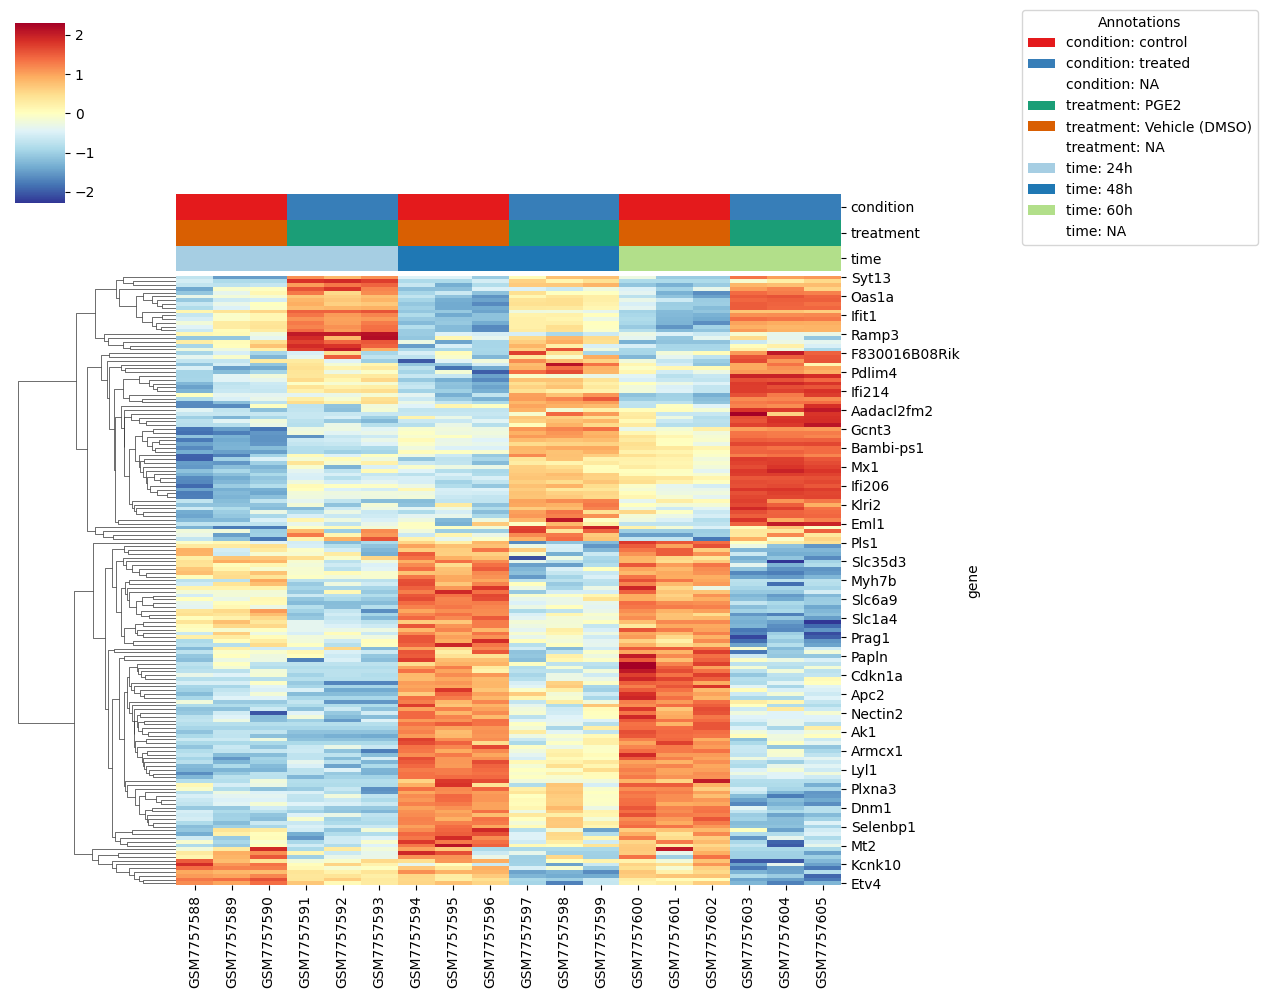

✅ Clustermap rendered successfully.


In [15]:
annotate_clustermap_with_metadata(grapher_cp, metadata_df)